In [1]:
import requests
import numpy as np
import unicodedata
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from shapely.geometry import Point
import cartopy.feature as cfeature
from geopy.geocoders import Nominatim
from pysus.ftp.databases.sih import SIH
from geopy.extra.rate_limiter import RateLimiter

# Arquivo "Internações limpo"

In [2]:
sih = SIH().load()

In [3]:
sih.metadata

{'long_name': 'Sistema de Informações Hospitalares',
 'source': ('https://datasus.saude.gov.br/acesso-a-informacao/morbidade-hospitalar-do-sus-sih-sus/',
  'https://datasus.saude.gov.br/acesso-a-informacao/producao-hospitalar-sih-sus/'),
 'description': 'A finalidade do AIH (Sistema SIHSUS) é a de transcrever todos os atendimentos que provenientes de internações hospitalares que foram financiadas pelo SUS, e após o processamento, gerarem relatórios para os gestores que lhes possibilitem fazer os pagamentos dos estabelecimentos de saúde. Além disso, o nível Federal recebe mensalmente uma base de dados de todas as internações autorizadas (aprovadas ou não para pagamento) para que possam ser repassados às Secretarias de Saúde os valores de Produção de Média e Alta complexidade além dos valores de CNRAC, FAEC e de Hospitais Universitários – em suas variadas formas de contrato de gestão.'}

In [4]:
sih.load()

SIH - Sistema de Informações Hospitalares

In [5]:
sih.groups

{'RD': 'AIH Reduzida',
 'RJ': 'AIH Rejeitada',
 'ER': 'AIH Rejeitada com erro',
 'SP': 'Serviços Profissionais',
 'CH': 'Cadastro Hospitalar',
 'CM': ''}

In [6]:
files = sih.get_files("SP", uf="RS", year=2023)

In [7]:
parquets = sih.download(files)
parquets

17899859it [00:00, 1727944261.16it/s]                                           


[/home/vini-pedroso/pysus/SPRS2301.parquet,
 /home/vini-pedroso/pysus/SPRS2302.parquet,
 /home/vini-pedroso/pysus/SPRS2303.parquet,
 /home/vini-pedroso/pysus/SPRS2304.parquet,
 /home/vini-pedroso/pysus/SPRS2305.parquet,
 /home/vini-pedroso/pysus/SPRS2306.parquet,
 /home/vini-pedroso/pysus/SPRS2307.parquet,
 /home/vini-pedroso/pysus/SPRS2308.parquet,
 /home/vini-pedroso/pysus/SPRS2309.parquet,
 /home/vini-pedroso/pysus/SPRS2310.parquet,
 /home/vini-pedroso/pysus/SPRS2311.parquet,
 /home/vini-pedroso/pysus/SPRS2312.parquet]

In [8]:
data =parquets[8].to_dataframe()

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1019593 entries, 0 to 1019592
Data columns (total 36 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   SP_GESTOR   1019593 non-null  string
 1   SP_UF       1019593 non-null  string
 2   SP_AA       1019593 non-null  string
 3   SP_MM       1019593 non-null  string
 4   SP_CNES     1019593 non-null  string
 5   SP_NAIH     1019593 non-null  string
 6   SP_PROCREA  1019593 non-null  string
 7   SP_DTINTER  1019593 non-null  string
 8   SP_DTSAIDA  1019593 non-null  string
 9   SP_NUM_PR   1019593 non-null  string
 10  SP_TIPO     1019593 non-null  string
 11  SP_CPFCGC   1019593 non-null  string
 12  SP_ATOPROF  1019593 non-null  string
 13  SP_TP_ATO   1019593 non-null  string
 14  SP_QTD_ATO  1019593 non-null  string
 15  SP_PTSP     1019593 non-null  string
 16  SP_NF       1019593 non-null  string
 17  SP_VALATO   1019593 non-null  string
 18  SP_M_HOSP   1019593 non-null  string
 19  

In [10]:
data_clean = data.drop(['SP_NUM_PR', 'SP_TIPO'], axis='columns')

In [11]:
data_clean = data.drop(['SP_GESTOR','SP_NUM_PR', 'SP_TIPO', 'SP_TP_ATO','SP_CPFCGC', 'SP_QTD_ATO', 'SP_PTSP', 'SP_NF', 'SP_COMPLEX', 'SP_FINANC', 'SP_CO_FAEC', 'SP_PF_DOC', 'SP_PJ_DOC','IN_TP_VAL', 'SEQUENCIA', 'REMESSA', 'SERV_CLA', 'SP_CIDPRI', 'SP_CIDSEC', 'SP_U_AIH', 'SP_PF_CBO'], axis='columns')

In [12]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1019593 entries, 0 to 1019592
Data columns (total 15 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   SP_UF       1019593 non-null  string
 1   SP_AA       1019593 non-null  string
 2   SP_MM       1019593 non-null  string
 3   SP_CNES     1019593 non-null  string
 4   SP_NAIH     1019593 non-null  string
 5   SP_PROCREA  1019593 non-null  string
 6   SP_DTINTER  1019593 non-null  string
 7   SP_DTSAIDA  1019593 non-null  string
 8   SP_ATOPROF  1019593 non-null  string
 9   SP_VALATO   1019593 non-null  string
 10  SP_M_HOSP   1019593 non-null  string
 11  SP_M_PAC    1019593 non-null  string
 12  SP_DES_HOS  1019593 non-null  string
 13  SP_DES_PAC  1019593 non-null  string
 14  SP_QT_PROC  1019593 non-null  string
dtypes: string(15)
memory usage: 116.7 MB


## Descrição das colunas do dataset após primeira filtragem:

In [13]:
arquivo = 'Nomes_cidades'
codigo_cidade = {}
with open(arquivo, 'r') as f:
    linhas = f.readlines()

for linha in linhas:
    partes = linha.split()
    codigo_cid = partes[0]
    nome_cidade = ' '.join(partes[2:-1])
    codigo_cidade[codigo_cid] = nome_cidade

In [14]:
data_clean['SP_CIDADE_H'] = data_clean['SP_M_HOSP'].map(codigo_cidade)
print(data_clean)

        SP_UF SP_AA SP_MM  SP_CNES        SP_NAIH  SP_PROCREA SP_DTINTER  \
0          43  2023    09  2252694  4323105050374  0303010037   20230707   
1          43  2023    09  2252694  4323105050374  0303010037   20230707   
2          43  2023    09  2252694  4323105050374  0303010037   20230707   
3          43  2023    09  2252694  4323105050374  0303010037   20230707   
4          43  2023    09  2252694  4323105050374  0303010037   20230707   
...       ...   ...   ...      ...            ...         ...        ...   
1019588    43  2023    09  7092571  4323106444316  0403020050   20230706   
1019589    43  2023    09  7092571  4323106444316  0403020050   20230706   
1019590    43  2023    09  7092571  4323106444316  0403020050   20230706   
1019591    43  2023    09  7092571  4323106444316  0403020050   20230706   
1019592    43  2023    09  7092571  4323106444316  0403020050   20230706   

        SP_DTSAIDA  SP_ATOPROF       SP_VALATO SP_M_HOSP SP_M_PAC SP_DES_HOS  \
0      

In [15]:
data_clean['SP_CIDADE_P'] = data_clean['SP_M_PAC'].map(codigo_cidade)
print(data_clean)

        SP_UF SP_AA SP_MM  SP_CNES        SP_NAIH  SP_PROCREA SP_DTINTER  \
0          43  2023    09  2252694  4323105050374  0303010037   20230707   
1          43  2023    09  2252694  4323105050374  0303010037   20230707   
2          43  2023    09  2252694  4323105050374  0303010037   20230707   
3          43  2023    09  2252694  4323105050374  0303010037   20230707   
4          43  2023    09  2252694  4323105050374  0303010037   20230707   
...       ...   ...   ...      ...            ...         ...        ...   
1019588    43  2023    09  7092571  4323106444316  0403020050   20230706   
1019589    43  2023    09  7092571  4323106444316  0403020050   20230706   
1019590    43  2023    09  7092571  4323106444316  0403020050   20230706   
1019591    43  2023    09  7092571  4323106444316  0403020050   20230706   
1019592    43  2023    09  7092571  4323106444316  0403020050   20230706   

        SP_DTSAIDA  SP_ATOPROF       SP_VALATO SP_M_HOSP SP_M_PAC SP_DES_HOS  \
0      

In [16]:
# String GRANDE DO SUL precisa ser retirada do dataset
rs = 'GRANDE DO SUL'
data_clean['SP_CIDADE_H'] = data_clean['SP_CIDADE_H'].str.replace(rs, '').str.strip()
data_clean['SP_CIDADE_P'] = data_clean['SP_CIDADE_P'].str.replace(rs, '').str.strip()

print(data_clean)

        SP_UF SP_AA SP_MM  SP_CNES        SP_NAIH  SP_PROCREA SP_DTINTER  \
0          43  2023    09  2252694  4323105050374  0303010037   20230707   
1          43  2023    09  2252694  4323105050374  0303010037   20230707   
2          43  2023    09  2252694  4323105050374  0303010037   20230707   
3          43  2023    09  2252694  4323105050374  0303010037   20230707   
4          43  2023    09  2252694  4323105050374  0303010037   20230707   
...       ...   ...   ...      ...            ...         ...        ...   
1019588    43  2023    09  7092571  4323106444316  0403020050   20230706   
1019589    43  2023    09  7092571  4323106444316  0403020050   20230706   
1019590    43  2023    09  7092571  4323106444316  0403020050   20230706   
1019591    43  2023    09  7092571  4323106444316  0403020050   20230706   
1019592    43  2023    09  7092571  4323106444316  0403020050   20230706   

        SP_DTSAIDA  SP_ATOPROF       SP_VALATO SP_M_HOSP SP_M_PAC SP_DES_HOS  \
0      

In [17]:
nulos_p = data_clean['SP_CIDADE_P'].isna().sum()
nulos_h = data_clean['SP_CIDADE_H'].isna().sum()
print(f"Total de valores nulos na coluna 'SP_CIDADE_P': {nulos_p}")
print(f"Total de valores nulos na coluna 'SP_CIDADE_H': {nulos_h}")

Total de valores nulos na coluna 'SP_CIDADE_P': 3525
Total de valores nulos na coluna 'SP_CIDADE_H': 0


In [18]:
codigos_nulos = data_clean[data_clean['SP_CIDADE_P'].isnull()]['SP_M_PAC'].unique()

print("Códigos SP_M_HOSP com valores nulos na coluna SP_CIDADE_H:")
print(codigos_nulos)

Códigos SP_M_HOSP com valores nulos na coluna SP_CIDADE_H:
<StringArray>
['421720', '421225', '421870', '420140', '420750', '110004', '310350',
 '320500', '150775', '130440', '330540', '220795', '130260', '420419',
 '431454', '140045', '355030', '530010', '292740', '316040', '411950',
 '420910', '420430', '420420', '421800', '160030', '421650', '420540',
 '420195', '120025', '110032', '110020', '420820', '421600', '312770',
 '210090', '411330', '421130', '412200', '410140', '350850', '410302',
 '412810', '410370', '420545', '292070', '410690', '353930', '251610',
 '110002', '420570', '421880', '352940', '110140', '421270', '412370',
 '330490', '311860', '420830', '354870', '420840', '412625', '351830',
 '412680', '330414', '354880', '353980', '421770', '291050', '421190',
 '420700', '150619', '421280', '420460', '293077', '410965', '411990',
 '420610', '313055', '510320', '421890', '330455', '410040', '421660',
 '410480']
Length: 85, dtype: string


In [19]:
arquivo = 'Nomes_cidades_externas'
codigo_cidade_externa = {}

with open(arquivo, 'r') as f:
    linhas = f.readlines()

for linha in linhas:
    partes = linha.split()    
    codigo_cid = partes[0]
    
    nome_cidade = ' '.join(partes[2:-1])
    codigo_cidade_externa[codigo_cid] = nome_cidade



In [20]:
def verifica_cidade_exterior(sp_m_pac):
    if sp_m_pac not in codigo_cidade:
        return codigo_cidade_externa.get(sp_m_pac, 'Cidade do RS')
    else:
        return None
data_clean['SP_CIDADE_P_EXT'] = data_clean['SP_M_PAC'].apply(lambda x: verifica_cidade_exterior(x))
print(data_clean)

        SP_UF SP_AA SP_MM  SP_CNES        SP_NAIH  SP_PROCREA SP_DTINTER  \
0          43  2023    09  2252694  4323105050374  0303010037   20230707   
1          43  2023    09  2252694  4323105050374  0303010037   20230707   
2          43  2023    09  2252694  4323105050374  0303010037   20230707   
3          43  2023    09  2252694  4323105050374  0303010037   20230707   
4          43  2023    09  2252694  4323105050374  0303010037   20230707   
...       ...   ...   ...      ...            ...         ...        ...   
1019588    43  2023    09  7092571  4323106444316  0403020050   20230706   
1019589    43  2023    09  7092571  4323106444316  0403020050   20230706   
1019590    43  2023    09  7092571  4323106444316  0403020050   20230706   
1019591    43  2023    09  7092571  4323106444316  0403020050   20230706   
1019592    43  2023    09  7092571  4323106444316  0403020050   20230706   

        SP_DTSAIDA  SP_ATOPROF       SP_VALATO SP_M_HOSP SP_M_PAC SP_DES_HOS  \
0      

In [21]:
substituicoes = {
    'CATARINA': '',
    'GERAIS ': '',
    'PAULO ': '',
    'DE JANEIRO ': '',
    'GROSSO DO SUL ': '',
    'GROSSO ': ''
}

data_clean['SP_CIDADE_P_EXT'] = data_clean['SP_CIDADE_P_EXT'].replace(substituicoes, regex=True).str.strip()

tipos_dados = data_clean['SP_CIDADE_P_EXT'].unique()
print(tipos_dados)

[None 'SÃO MIGUEL DO OESTE' 'PASSO DE TORRES' 'TUBARÃO' 'ARARANGUÁ'
 'INDAIAL' 'CACOAL' 'ARAGUARI' 'SANTO SERRA' 'SAPUCAIA' 'URUCURITUBA'
 'NOVA SANTA RITA' 'MANAUS' 'CHAPADÃO DO LAGEADO' 'Cidade do RS'
 'PACARAIMA' 'SÃO PAULO' 'BRASÍLIA' 'SALVADOR' 'SANTO ANTÔNIO DO MONTE'
 'PIRAQUARA' 'JOINVILLE' 'CONCÓRDIA' 'CHAPECÓ' 'TIJUCAS' 'MACAPÁ'
 'SÃO JOAQUIM' 'FLORIANÓPOLIS' 'BALNEÁRIO ARROIO DO SILVA'
 'EPITACIOLÂNDIA' 'SÃO MIGUEL DO GUAPORÉ' 'PORTO VELHO' 'ITAJAÍ'
 'SÃO CARLOS' 'GOVERNADOR VALADARES' 'ARAIOSES' 'LARANJEIRAS DO SUL'
 'NAVEGANTES' 'RIO AZUL' 'APUCARANA' 'CAÇAPAVA' 'BOA ESPERANÇA DO IGUAÇU'
 'UMUARAMA' 'CAMBÉ' 'FORQUILHINHA' 'MARAÚ' 'CURITIBA' 'PIRASSUNUNGA'
 'SOLEDADE' 'ARIQUEMES' 'GAROPABA' 'TURVO' 'MAUÁ' 'MONTE NEGRO'
 'PETROLÂNDIA' 'SANTA ISABEL DO IVAÍ' 'SÃO GONÇALO' 'CONTAGEM' 'ITAPEMA'
 'SÃO BERNARDO DO CAMPO' 'ITAPIRANGA' 'SARANDI' 'GUARAREMA' 'TAPEJARA'
 'QUEIMADOS' 'SÃO CAETANO DO SUL' 'POÁ' 'SOMBRIO' 'ENTRE RIOS' 'PALHOÇA'
 'IÇARA' 'RURÓPOLIS' 'BALNEÁRIO PIÇARRAS' 

In [22]:
# Substituir todos os valores None por 'Cidade do RS' na coluna SP_CIDADE_P_EXT
data_clean['SP_CIDADE_P_EXT'].fillna('Cidade do RS', inplace=True)
print(data_clean)

        SP_UF SP_AA SP_MM  SP_CNES        SP_NAIH  SP_PROCREA SP_DTINTER  \
0          43  2023    09  2252694  4323105050374  0303010037   20230707   
1          43  2023    09  2252694  4323105050374  0303010037   20230707   
2          43  2023    09  2252694  4323105050374  0303010037   20230707   
3          43  2023    09  2252694  4323105050374  0303010037   20230707   
4          43  2023    09  2252694  4323105050374  0303010037   20230707   
...       ...   ...   ...      ...            ...         ...        ...   
1019588    43  2023    09  7092571  4323106444316  0403020050   20230706   
1019589    43  2023    09  7092571  4323106444316  0403020050   20230706   
1019590    43  2023    09  7092571  4323106444316  0403020050   20230706   
1019591    43  2023    09  7092571  4323106444316  0403020050   20230706   
1019592    43  2023    09  7092571  4323106444316  0403020050   20230706   

        SP_DTSAIDA  SP_ATOPROF       SP_VALATO SP_M_HOSP SP_M_PAC SP_DES_HOS  \
0      

/tmp/ipykernel_3714/3527762726.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_clean['SP_CIDADE_P_EXT'].fillna('Cidade do RS', inplace=True)


In [23]:
contando_dados= data_clean['SP_CIDADE_P_EXT'].value_counts()
contando_dados

SP_CIDADE_P_EXT
Cidade do RS             1016169
IÇARA                        206
PASSO DE TORRES              179
GAROPABA                     164
SÃO MIGUEL DO GUAPORÉ        147
                          ...   
COLÍDER                        3
CASCAVEL                       3
EPITACIOLÂNDIA                 2
CONTAGEM                       2
ALMIRANTE TAMANDARÉ            2
Name: count, Length: 84, dtype: int64

In [24]:
data_clean['SP_CIDADE_P'].fillna('Cidade de fora do RS', inplace=True)

/tmp/ipykernel_3714/321287065.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_clean['SP_CIDADE_P'].fillna('Cidade de fora do RS', inplace=True)


In [25]:
nulos_p = data_clean['SP_CIDADE_P'].isna().sum()
nulos_ext = data_clean['SP_CIDADE_P_EXT'].isna().sum()
nulos_h = data_clean['SP_CIDADE_H'].isna().sum()
print(f"Total de valores nulos na coluna 'SP_CIDADE_P': {nulos_p}")
print(f"Total de valores nulos na coluna 'SP_CIDADE_P_EXT': {nulos_ext}")
print(f"Total de valores nulos na coluna 'SP_CIDADE_H': {nulos_h}")

Total de valores nulos na coluna 'SP_CIDADE_P': 0
Total de valores nulos na coluna 'SP_CIDADE_P_EXT': 0
Total de valores nulos na coluna 'SP_CIDADE_H': 0


## Criando colunas de tipo de procedimento e ato profissional

In [26]:
arquivo = 'codigo_procedimento'
codigo_procedimento = {}

with open(arquivo, 'r') as f:
    linhas = f.readlines()

for linha in linhas:
    partes = linha.strip().split()
    codigo = partes[0]
    titulo = []

    for parte in partes[1:]:
        if any(char.isdigit() for char in parte):
            break
        titulo.append(parte)
    
    # Juntar o nome da atividade
    titulo = ' '.join(titulo)
    
    # Adicionar ao dicionário
    codigo_procedimento[codigo] = titulo

# Exibir o dicionário
#print(codigo_procedimento)

In [27]:
data_clean['SP_N_PROC'] = data_clean['SP_PROCREA'].map(codigo_procedimento)
contando_dados= data_clean['SP_N_PROC'].value_counts()
contando_dados

SP_N_PROC
TRATAMENTO DE PNEUMONIAS OU INFLUENZA (GRIPE)                                      63436
TRATAMENTO DE OUTRAS DOENÇAS BACTERIANAS                                           63221
TRATAMENTO DE ACIDENTE VASCULAR CEREBRAL - AVC (ISQUEMICO OU HEMORRAGICO AGUDO)    32069
PARTO CESARIANO                                                                    31442
TRATAMENTO DE INSUFICIENCIA CARDIACA                                               31217
                                                                                   ...  
RESSECCAO ENDOSCOPICA DA EXTREMIDADE DISTAL DO URETER                                  3
REPOSICIONAMENTO DE LENTE INTRAOCULAR                                                  3
RETINOPEXIA C/ INTROFLEXAO ESCLERAL                                                    3
FECHAMENTO DE FISTULA DE RETO                                                          3
CICLODIALISE                                                                           2
Name: count

In [28]:
data_clean['SP_N_ATOS'] = data_clean['SP_ATOPROF'].map(codigo_procedimento)
print(data_clean)

        SP_UF SP_AA SP_MM  SP_CNES        SP_NAIH  SP_PROCREA SP_DTINTER  \
0          43  2023    09  2252694  4323105050374  0303010037   20230707   
1          43  2023    09  2252694  4323105050374  0303010037   20230707   
2          43  2023    09  2252694  4323105050374  0303010037   20230707   
3          43  2023    09  2252694  4323105050374  0303010037   20230707   
4          43  2023    09  2252694  4323105050374  0303010037   20230707   
...       ...   ...   ...      ...            ...         ...        ...   
1019588    43  2023    09  7092571  4323106444316  0403020050   20230706   
1019589    43  2023    09  7092571  4323106444316  0403020050   20230706   
1019590    43  2023    09  7092571  4323106444316  0403020050   20230706   
1019591    43  2023    09  7092571  4323106444316  0403020050   20230706   
1019592    43  2023    09  7092571  4323106444316  0403020050   20230706   

        SP_DTSAIDA  SP_ATOPROF       SP_VALATO SP_M_HOSP SP_M_PAC SP_DES_HOS  \
0      

### Limpando Colunas com nulos e criando csv

In [29]:
nulos_proc = data_clean['SP_N_PROC'].isna().sum()
nulos_atos = data_clean['SP_N_ATOS'].isna().sum()
print(f"Total de valores nulos na coluna 'SP_N_PROC': {nulos_proc}")
print(f"Total de valores nulos na coluna 'SP_N_ATOS': {nulos_atos}")

print()
dados_proc = data_clean['SP_N_PROC'].notna().sum()
dados_atos = data_clean['SP_N_ATOS'].notna().sum()
print(f"Total de valores NAO nulos na coluna 'SP_N_PROC': {dados_proc}")
print(f"Total de valores NAO nulos na coluna 'SP_N_ATOS': {dados_atos}")

Total de valores nulos na coluna 'SP_N_PROC': 134934
Total de valores nulos na coluna 'SP_N_ATOS': 100400

Total de valores NAO nulos na coluna 'SP_N_PROC': 884659
Total de valores NAO nulos na coluna 'SP_N_ATOS': 919193


In [30]:
def verificar_codigos(codigos, dicionario):
    presentes = []
    ausentes = []
    for codigo in codigos:
        if codigo in dicionario:
            presentes.append(codigo)
        else:
            ausentes.append(codigo)
    return presentes, ausentes

In [31]:
nulos_proc = data_clean['SP_N_PROC'].isna().sum()
nulos_atos = data_clean['SP_N_ATOS'].isna().sum()
print(f"Total de valores nulos na coluna 'SP_N_PROC': {nulos_proc}")
print(f"Total de valores nulos na coluna 'SP_N_ATOS': {nulos_atos}")

print()
dados_proc = data_clean['SP_N_PROC'].notna().sum()
dados_atos = data_clean['SP_N_ATOS'].notna().sum()
print(f"Total de valores NAO nulos na coluna 'SP_N_PROC': {dados_proc}")
print(f"Total de valores NAO nulos na coluna 'SP_N_ATOS': {dados_atos}")

Total de valores nulos na coluna 'SP_N_PROC': 134934
Total de valores nulos na coluna 'SP_N_ATOS': 100400

Total de valores NAO nulos na coluna 'SP_N_PROC': 884659
Total de valores NAO nulos na coluna 'SP_N_ATOS': 919193


In [32]:
data_clean.dropna(subset=['SP_N_PROC'], inplace= True)
data_clean.dropna(subset=['SP_N_ATOS'], inplace= True)


In [33]:
data_limpo = data_clean.drop_duplicates()

In [34]:
data_limpo.info()
#data_limpo.to_csv('dados_limpos.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 753603 entries, 0 to 1019589
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   SP_UF            753603 non-null  string
 1   SP_AA            753603 non-null  string
 2   SP_MM            753603 non-null  string
 3   SP_CNES          753603 non-null  string
 4   SP_NAIH          753603 non-null  string
 5   SP_PROCREA       753603 non-null  string
 6   SP_DTINTER       753603 non-null  string
 7   SP_DTSAIDA       753603 non-null  string
 8   SP_ATOPROF       753603 non-null  string
 9   SP_VALATO        753603 non-null  string
 10  SP_M_HOSP        753603 non-null  string
 11  SP_M_PAC         753603 non-null  string
 12  SP_DES_HOS       753603 non-null  string
 13  SP_DES_PAC       753603 non-null  string
 14  SP_QT_PROC       753603 non-null  string
 15  SP_CIDADE_H      753603 non-null  object
 16  SP_CIDADE_P      753603 non-null  object
 17  SP_CIDADE_P_EX

## Nova descrição das colunas

# Arquivo "Geopandas"

In [35]:
dados = pd.read_csv('dados_limpos.csv')

In [36]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753603 entries, 0 to 753602
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   SP_UF            753603 non-null  int64  
 1   SP_AA            753603 non-null  int64  
 2   SP_MM            753603 non-null  int64  
 3   SP_CNES          753603 non-null  int64  
 4   SP_NAIH          753603 non-null  int64  
 5   SP_PROCREA       753603 non-null  int64  
 6   SP_DTINTER       753603 non-null  int64  
 7   SP_DTSAIDA       753603 non-null  int64  
 8   SP_ATOPROF       753603 non-null  int64  
 9   SP_VALATO        753603 non-null  float64
 10  SP_M_HOSP        753603 non-null  int64  
 11  SP_M_PAC         753603 non-null  int64  
 12  SP_DES_HOS       753603 non-null  int64  
 13  SP_DES_PAC       753603 non-null  int64  
 14  SP_QT_PROC       753603 non-null  int64  
 15  SP_CIDADE_H      753603 non-null  object 
 16  SP_CIDADE_P      751732 non-null  obje

In [37]:
nulos = dados.isnull().sum()
print(nulos)

SP_UF                 0
SP_AA                 0
SP_MM                 0
SP_CNES               0
SP_NAIH               0
SP_PROCREA            0
SP_DTINTER            0
SP_DTSAIDA            0
SP_ATOPROF            0
SP_VALATO             0
SP_M_HOSP             0
SP_M_PAC              0
SP_DES_HOS            0
SP_DES_PAC            0
SP_QT_PROC            0
SP_CIDADE_H           0
SP_CIDADE_P        1871
SP_CIDADE_P_EXT       0
SP_N_PROC             0
SP_N_ATOS             0
dtype: int64


In [38]:
municipios = pd.read_csv('municipios.csv', sep=',', encoding='utf-8')  # Verifique o separador e a codificação correta

In [39]:
dados = dados.dropna(subset=['SP_CIDADE_P'])

In [40]:
municipios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   codigo_ibge   5570 non-null   int64  
 1   nome          5570 non-null   object 
 2   latitude      5570 non-null   float64
 3   longitude     5570 non-null   float64
 4   ddd           5570 non-null   int64  
 5   fuso_horario  5570 non-null   object 
dtypes: float64(2), int64(2), object(2)
memory usage: 261.2+ KB


In [41]:
# Função para normalizar nomes de cidades
def normalize_city_name(name):
    if isinstance(name, str):
        return ''.join(c for c in unicodedata.normalize('NFKD', name) if not unicodedata.combining(c)).lower().strip()
    else:
        return ''

In [42]:
# Aplicar normalização às colunas relevantes
dados['SP_CIDADE_H_norm'] = dados['SP_CIDADE_H'].apply(normalize_city_name)
dados['SP_CIDADE_P_norm'] = dados['SP_CIDADE_P'].apply(normalize_city_name)
dados['SP_CIDADE_P_EXT_norm'] = dados['SP_CIDADE_P_EXT'].apply(normalize_city_name)
municipios['nome_norm'] = municipios['nome'].apply(normalize_city_name)

In [43]:
# Mesclar os DataFrames utilizando as colunas normalizadas
dados = dados.merge(municipios[['nome_norm', 'latitude', 'longitude']], how='left', left_on='SP_CIDADE_H_norm', right_on='nome_norm')
dados.rename(columns={'latitude': 'latitude_h', 'longitude': 'longitude_h'}, inplace=True)
dados.drop(columns=['SP_CIDADE_H_norm', 'nome_norm'], inplace=True)

dados = dados.merge(municipios[['nome_norm', 'latitude', 'longitude']], how='left', left_on='SP_CIDADE_P_norm', right_on='nome_norm')
dados.rename(columns={'latitude': 'latitude_p', 'longitude': 'longitude_p'}, inplace=True)
dados.drop(columns=['SP_CIDADE_P_norm', 'nome_norm'], inplace=True)

dados = dados.merge(municipios[['nome_norm', 'latitude', 'longitude']], how='left', left_on='SP_CIDADE_P_EXT_norm', right_on='nome_norm')
dados.rename(columns={'latitude': 'latitude_p_ext', 'longitude': 'longitude_p_ext'}, inplace=True)
dados.drop(columns=['SP_CIDADE_P_EXT_norm', 'nome_norm'], inplace=True)

In [44]:
# # Mesclar para 'SP_CIDADE_H'
# dados = dados.merge(municipios[['nome', 'latitude', 'longitude']],
#                     how='left', left_on='SP_CIDADE_H', right_on='nome')
# dados.rename(columns={'latitude': 'latitude_h', 'longitude': 'longitude_h'}, inplace=True)
# dados.drop(columns=['nome'], inplace=True)  # Drop a coluna auxiliar 'nome' do município
# #
# # Mesclar para 'SP_CIDADE_P'
# dados = dados.merge(municipios[['nome', 'latitude', 'longitude']],
#                     how='left', left_on='SP_CIDADE_P', right_on='nome')
# dados.rename(columns={'latitude': 'latitude_p', 'longitude': 'longitude_p'}, inplace=True)
# dados.drop(columns=['nome'], inplace=True)  # Drop a coluna auxiliar 'nome' do município

# # Mesclar para 'SP_CIDADE_P_EXT'
# dados = dados.merge(municipios[['nome', 'latitude', 'longitude']],
#                     how='left', left_on='SP_CIDADE_P_EXT', right_on='nome')
# dados.rename(columns={'latitude': 'latitude_p_ext', 'longitude': 'longitude_p_ext'}, inplace=True)
# dados.drop(columns=['nome'], inplace=True)  # Drop a coluna auxiliar 'nome' do município

# # Exibir o resultado
# print(dados.head())

In [45]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949348 entries, 0 to 949347
Data columns (total 26 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   SP_UF            949348 non-null  int64  
 1   SP_AA            949348 non-null  int64  
 2   SP_MM            949348 non-null  int64  
 3   SP_CNES          949348 non-null  int64  
 4   SP_NAIH          949348 non-null  int64  
 5   SP_PROCREA       949348 non-null  int64  
 6   SP_DTINTER       949348 non-null  int64  
 7   SP_DTSAIDA       949348 non-null  int64  
 8   SP_ATOPROF       949348 non-null  int64  
 9   SP_VALATO        949348 non-null  float64
 10  SP_M_HOSP        949348 non-null  int64  
 11  SP_M_PAC         949348 non-null  int64  
 12  SP_DES_HOS       949348 non-null  int64  
 13  SP_DES_PAC       949348 non-null  int64  
 14  SP_QT_PROC       949348 non-null  int64  
 15  SP_CIDADE_H      949348 non-null  object 
 16  SP_CIDADE_P      949348 non-null  obje

In [46]:
nulos = dados.isnull().sum()

In [47]:
print(nulos)

SP_UF                   0
SP_AA                   0
SP_MM                   0
SP_CNES                 0
SP_NAIH                 0
SP_PROCREA              0
SP_DTINTER              0
SP_DTSAIDA              0
SP_ATOPROF              0
SP_VALATO               0
SP_M_HOSP               0
SP_M_PAC                0
SP_DES_HOS              0
SP_DES_PAC              0
SP_QT_PROC              0
SP_CIDADE_H             0
SP_CIDADE_P             0
SP_CIDADE_P_EXT         0
SP_N_PROC               0
SP_N_ATOS               0
latitude_h              0
longitude_h             0
latitude_p           3186
longitude_p          3186
latitude_p_ext     947113
longitude_p_ext    947113
dtype: int64


In [48]:
print(dados.columns)

Index(['SP_UF', 'SP_AA', 'SP_MM', 'SP_CNES', 'SP_NAIH', 'SP_PROCREA',
       'SP_DTINTER', 'SP_DTSAIDA', 'SP_ATOPROF', 'SP_VALATO', 'SP_M_HOSP',
       'SP_M_PAC', 'SP_DES_HOS', 'SP_DES_PAC', 'SP_QT_PROC', 'SP_CIDADE_H',
       'SP_CIDADE_P', 'SP_CIDADE_P_EXT', 'SP_N_PROC', 'SP_N_ATOS',
       'latitude_h', 'longitude_h', 'latitude_p', 'longitude_p',
       'latitude_p_ext', 'longitude_p_ext'],
      dtype='object')


In [49]:
dados = dados.loc[:,~dados.columns.duplicated()]

In [50]:
# Criando uma máscara booleana para identificar linhas onde a coluna SP_CIDADE_P é nula
mask = dados['latitude_p'].isnull()

# Aplicando a máscara para filtrar as linhas e selecionando as colunas desejadas para visualização
linhas_nulas = dados.loc[mask, ['SP_DES_HOS','SP_CIDADE_H', 'SP_CIDADE_P',
                             'SP_CIDADE_P_EXT', 'SP_N_PROC', 'SP_N_ATOS',
                             'latitude_h', 'longitude_h', 'latitude_p', 'longitude_p',
                             'latitude_p_ext', 'longitude_p_ext']]

# Imprimindo algumas linhas para visualização
print(linhas_nulas.head())

       SP_DES_HOS   SP_CIDADE_H           SP_CIDADE_P SP_CIDADE_P_EXT  \
14731           1  PORTO ALEGRE  Cidade de fora do RS       ARARANGUÁ   
14732           1  PORTO ALEGRE  Cidade de fora do RS       ARARANGUÁ   
14733           1  PORTO ALEGRE  Cidade de fora do RS       ARARANGUÁ   
17811           1  PORTO ALEGRE  Cidade de fora do RS          CACOAL   
17812           1  PORTO ALEGRE  Cidade de fora do RS          CACOAL   

                                               SP_N_PROC  \
14731  TRATAMENTO DE INTERCORRENCIA POS-TRANSPLANTE D...   
14732  TRATAMENTO DE INTERCORRENCIA POS-TRANSPLANTE D...   
14733  TRATAMENTO DE INTERCORRENCIA POS-TRANSPLANTE D...   
17811  TRATAMENTO DE INTERCORRENCIA POS-TRANSPLANTE D...   
17812  TRATAMENTO DE INTERCORRENCIA POS-TRANSPLANTE D...   

                                               SP_N_ATOS  latitude_h  \
14731               CULTURA PARA IDENTIFICACAO DE FUNGOS    -30.0318   
14732                               BACTEROSCOPIA (GRAM)

In [51]:
# Remover duplicatas mantendo apenas a primeira ocorrência
dados = dados.drop_duplicates()

# Exibir o resultado
print(dados.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949348 entries, 0 to 949347
Data columns (total 26 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   SP_UF            949348 non-null  int64  
 1   SP_AA            949348 non-null  int64  
 2   SP_MM            949348 non-null  int64  
 3   SP_CNES          949348 non-null  int64  
 4   SP_NAIH          949348 non-null  int64  
 5   SP_PROCREA       949348 non-null  int64  
 6   SP_DTINTER       949348 non-null  int64  
 7   SP_DTSAIDA       949348 non-null  int64  
 8   SP_ATOPROF       949348 non-null  int64  
 9   SP_VALATO        949348 non-null  float64
 10  SP_M_HOSP        949348 non-null  int64  
 11  SP_M_PAC         949348 non-null  int64  
 12  SP_DES_HOS       949348 non-null  int64  
 13  SP_DES_PAC       949348 non-null  int64  
 14  SP_QT_PROC       949348 non-null  int64  
 15  SP_CIDADE_H      949348 non-null  object 
 16  SP_CIDADE_P      949348 non-null  obje

In [52]:
# Substituir NaN em latitude_p e longitude_p por "cidades de fora RS"
dados['latitude_p_ext'].fillna('cidade do RS', inplace=True)
dados['longitude_p_ext'].fillna('cidade do RS', inplace=True)

# Exibir o resultado
print(dados.head())

   SP_UF  SP_AA  SP_MM  SP_CNES        SP_NAIH  SP_PROCREA  SP_DTINTER  \
0     43   2023      9  2252694  4323105050374   303010037    20230707   
1     43   2023      9  2252694  4323105050374   303010037    20230707   
2     43   2023      9  2252694  4323105050374   303010037    20230707   
3     43   2023      9  2252694  4323105050374   303010037    20230707   
4     43   2023      9  2252694  4323105050374   303010037    20230707   

   SP_DTSAIDA  SP_ATOPROF  SP_VALATO  ...  SP_CIDADE_P  SP_CIDADE_P_EXT  \
0    20230802   206010079      97.44  ...      PELOTAS     Cidade do RS   
1    20230802   206020031     136.41  ...      PELOTAS     Cidade do RS   
2    20230802   206030010     138.63  ...      PELOTAS     Cidade do RS   
3    20230802   206030037     138.63  ...      PELOTAS     Cidade do RS   
4    20230802   203010035      20.96  ...      PELOTAS     Cidade do RS   

                                  SP_N_PROC  \
0  TRATAMENTO DE OUTRAS DOENÇAS BACTERIANAS   
1  TRATAME

/tmp/ipykernel_3714/4003231006.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dados['latitude_p_ext'].fillna('cidade do RS', inplace=True)
/tmp/ipykernel_3714/4003231006.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'cidade do RS' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dados['latitude_p_ext'].fillna('cidade do RS', inplace=True)
/tmp/ipykernel_3714/4003231006.py:3: FutureWarning: A va

In [53]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949348 entries, 0 to 949347
Data columns (total 26 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   SP_UF            949348 non-null  int64  
 1   SP_AA            949348 non-null  int64  
 2   SP_MM            949348 non-null  int64  
 3   SP_CNES          949348 non-null  int64  
 4   SP_NAIH          949348 non-null  int64  
 5   SP_PROCREA       949348 non-null  int64  
 6   SP_DTINTER       949348 non-null  int64  
 7   SP_DTSAIDA       949348 non-null  int64  
 8   SP_ATOPROF       949348 non-null  int64  
 9   SP_VALATO        949348 non-null  float64
 10  SP_M_HOSP        949348 non-null  int64  
 11  SP_M_PAC         949348 non-null  int64  
 12  SP_DES_HOS       949348 non-null  int64  
 13  SP_DES_PAC       949348 non-null  int64  
 14  SP_QT_PROC       949348 non-null  int64  
 15  SP_CIDADE_H      949348 non-null  object 
 16  SP_CIDADE_P      949348 non-null  obje

In [54]:
contador = dados['longitude_p_ext'].value_counts()
print(contador)

longitude_p_ext
 cidade do RS    947113
-48.5477            128
-52.6152             92
-49.5925             84
-49722.0             83
                  ...  
-63.29                3
-40.8145              3
-51.0694              3
-43.2003              3
-68.7341              2
Name: count, Length: 77, dtype: int64


In [55]:
contagem_naih = dados['SP_NAIH'].nunique()

print(f"Quantidade de valores únicos na coluna SP_NAIH: {contagem_naih}")

Quantidade de valores únicos na coluna SP_NAIH: 58556


In [56]:
dados_sem_duplicatas = dados.drop_duplicates(subset=['SP_NAIH', 'SP_N_PROC'])

# Contar quantos procedimentos únicos cada paciente teve
contagem_procedimentos = dados_sem_duplicatas.groupby('SP_N_PROC')['SP_N_PROC'].size()

print(contagem_procedimentos)
valor = contagem_procedimentos.value_counts()
print(valor)

SP_N_PROC
AJUSTE MEDICAMENTOSO DE SITUACOES NEUROLOGICAS AGUDIZADAS                         104
ALARGAMENTO DA ENTRADA VAGINAL                                                      1
ALCOOLIZAÇÃO PERCUTÂNEA DE CARCINOMA HEPÁTICO                                       5
ALONGAMENTO / ENCURTAMENTO MIOTENDINOSO                                             3
ALONGAMENTO DE COLUMELA                                                             1
                                                                                 ... 
VITRECTOMIA POSTERIOR COM INFUSÃO DE PERFLUOCARBONO E ENDOLASER                    96
VITRECTOMIA POSTERIOR COM INFUSÃO DE PERFLUOCARBONO/ÓLEO DE SILICONE/ENDOLASER     75
VULVECTOMIA AMPLIADA C/ LINFADENECTOMIA EM ONCOLOGIA                                2
VULVECTOMIA SIMPLES                                                                 8
VULVECTOMIA SIMPLES POR TUMOR                                                       5
Name: SP_N_PROC, Length: 1045, dtype: int64


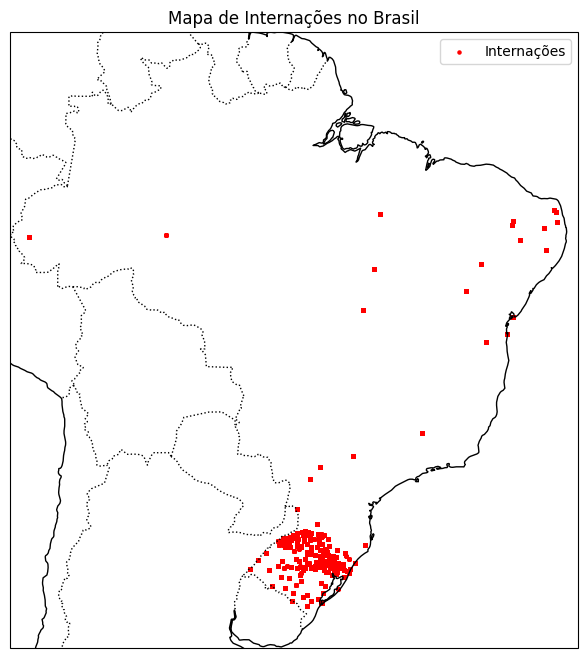

In [57]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 1. Criar as geometrias a partir dos dados originais
geometry = [Point(xy) for xy in zip(dados['longitude_h'], dados['latitude_h'])]

# 2. Criar o GeoDataFrame com o sistema de coordenadas WGS84 (EPSG:4326)
gdf = gpd.GeoDataFrame(dados, geometry=geometry, crs="EPSG:4326")

# 3. Filtrar valores inválidos (fora dos limites geográficos do sistema WGS84)
gdf = gdf[(gdf['longitude_h'] >= -180) & (gdf['longitude_h'] <= 180) &
          (gdf['latitude_h'] >= -90) & (gdf['latitude_h'] <= 90)]

# 4. Plotar os dados no mapa
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.set_extent([-74, -34, -35, 6], crs=ccrs.PlateCarree())  # Ajustar os limites para o Brasil
gdf.plot(ax=ax, marker='o', color='red', markersize=5, label='Internações')
plt.title('Mapa de Internações no Brasil')
plt.legend()
plt.show()


In [58]:
# gdf = gdf.to_crs(epsg=4326)


In [59]:
print(gdf.total_bounds)
print(gdf.is_empty.any())  # Deve retornar False
print(gdf.is_valid.all())  # Deve retornar True
print(gdf.geometry.y.min(), gdf.geometry.y.max())
print(dados[['longitude_h', 'latitude_h']].head())
print(dados[['longitude_h', 'latitude_h']].describe())


[-72.6756  -32.2327  -35.4581   -5.83802]
False
True
-32.2327 -5.83802
   longitude_h  latitude_h
0     -52.3371    -31.7649
1     -52.3371    -31.7649
2     -52.3371    -31.7649
3     -52.3371    -31.7649
4     -52.3371    -31.7649
         longitude_h     latitude_h
count  949348.000000  949348.000000
mean     -842.277115   -1906.636485
std      6283.711411    7198.735147
min    -54822.000000  -33525.000000
25%       -52.409100     -30.031800
50%       -51.206500     -29.912800
75%       -51.179200     -28.507900
max       -35.458100      -5.838020


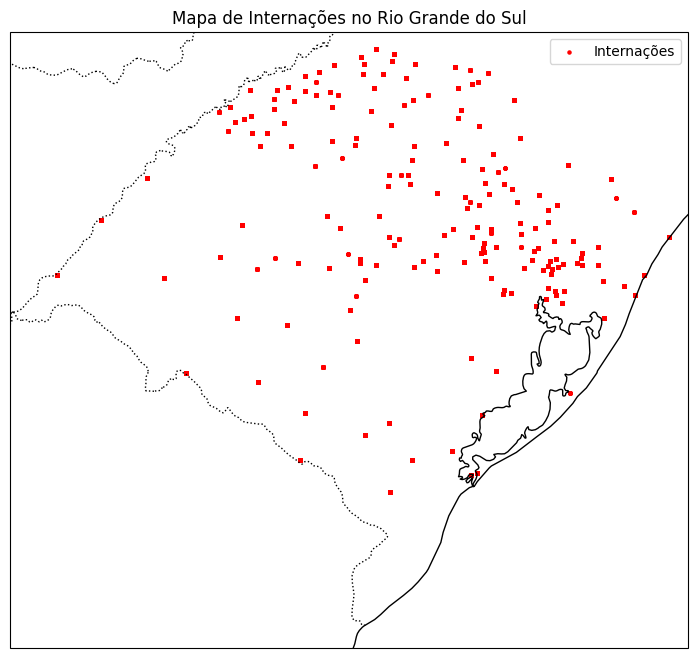

In [60]:
# 1. Criar as geometrias a partir dos dados originais
geometry = [Point(xy) for xy in zip(dados['longitude_h'], dados['latitude_h'])]

# 2. Criar o GeoDataFrame com o sistema de coordenadas WGS84 (EPSG:4326)
gdf = gpd.GeoDataFrame(dados, geometry=geometry, crs="EPSG:4326")

# 3. Filtrar valores inválidos (fora dos limites geográficos do sistema WGS84)
gdf = gdf[(gdf['longitude_h'] >= -180) & (gdf['longitude_h'] <= 180) &
          (gdf['latitude_h'] >= -90) & (gdf['latitude_h'] <= 90)]

# 4. Configurar o gráfico para usar o sistema de coordenadas
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Adicionar o mapa básico com limites de países
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

# Limitar o gráfico ao Rio Grande do Sul (coordenadas aproximadas)
ax.set_extent([-57.65, -49.5, -34.0, -27.0], crs=ccrs.PlateCarree())  # Ajuste os limites para o RS

# Plotar os pontos do GeoDataFrame no mapa
gdf.plot(ax=ax, marker='o', color='red', markersize=5, label='Internações')

# Adicionar título e legendas
plt.title('Mapa de Internações no Rio Grande do Sul')
plt.legend()
plt.show()

In [61]:
cidades_acima_menos25 = dados[dados['latitude_h'] < -25]

contagem_cidades_acima_menos25 = cidades_acima_menos25['SP_CIDADE_H'].nunique()

# Mostrar as linhas onde latitude_h está entre -25 e 0
linhas_latitude_entre_menos25_e_zero = dados[(dados['latitude_h'] > -25) & (dados['latitude_h'] <= 0)]

# Exibir os resultados
print(f"Cidades com latitude acima de -25: {contagem_cidades_acima_menos25}")
print("\nLinhas com latitude entre -25 e 0:")
print(linhas_latitude_entre_menos25_e_zero)

Cidades com latitude acima de -25: 224

Linhas com latitude entre -25 e 0:
        SP_UF  SP_AA  SP_MM  SP_CNES        SP_NAIH  SP_PROCREA  SP_DTINTER  \
62366      43   2023      9  2232081  4323102301397   303140046    20230827   
62367      43   2023      9  2232081  4323102301397   303140046    20230827   
62370      43   2023      9  2232081  4323102301397   303140046    20230827   
62371      43   2023      9  2232081  4323102301397   303140046    20230827   
62374      43   2023      9  2232081  4323102301397   303140046    20230827   
...       ...    ...    ...      ...            ...         ...         ...   
925156     43   2023      9  2235404  4323106968114   303140151    20230830   
925159     43   2023      9  2235404  4323106968114   303140151    20230830   
925160     43   2023      9  2235404  4323106968114   303140151    20230830   
925163     43   2023      9  2235404  4323106968114   303140151    20230830   
925164     43   2023      9  2235404  4323106968114   30

In [62]:
# Filtrar as cidades com latitude acima de -25
cidades_acima_menos25 = dados[dados['latitude_h'] > -25]

# Selecionar apenas as colunas de interesse: nome da cidade e latitude
resultado = cidades_acima_menos25[['SP_CIDADE_H', 'latitude_h']]

# Exibir os resultados
print("Cidades com latitude acima de -25:")
print(resultado)

Cidades com latitude acima de -25:
       SP_CIDADE_H  latitude_h
62366     ALVORADA    -12.4785
62367     ALVORADA    -12.4785
62370     ALVORADA    -12.4785
62371     ALVORADA    -12.4785
62374     ALVORADA    -12.4785
...            ...         ...
925156     SARANDI    -23.4441
925159     SARANDI    -23.4441
925160     SARANDI    -23.4441
925163     SARANDI    -23.4441
925164     SARANDI    -23.4441

[104940 rows x 2 columns]


In [63]:
# Filtrar as cidades com latitude acima de -25
cidades_acima_menos25 = dados[dados['latitude_h'] > -25]

# Contar o número de cidades únicas
numero_cidades_acima_menos25 = cidades_acima_menos25['SP_CIDADE_H'].nunique()

# Exibir o resultado
print(f"Número de cidades com latitude acima de -25: {numero_cidades_acima_menos25}")

Número de cidades com latitude acima de -25: 18


In [64]:
# Filtrar as cidades com latitude acima de -25
cidades_acima_menos25 = dados[dados['latitude_h'] > -25]

# Obter as informações relevantes (nome, latitude, longitude)
cidades_info = cidades_acima_menos25[['SP_CIDADE_H', 'latitude_h', 'longitude_h']].drop_duplicates()

# Exibir o resultado
print("Cidades com latitude acima de -25:")
for index, row in cidades_info.iterrows():
    print(f"Nome: {row['SP_CIDADE_H']}, Latitude: {row['latitude_h']}, Longitude: {row['longitude_h']}")

Cidades com latitude acima de -25:
Nome: ALVORADA, Latitude: -12.4785, Longitude: -49.1249
Nome: CACHOEIRINHA, Latitude: -6.1156, Longitude: -47.9234
Nome: CACHOEIRINHA, Latitude: -8.48668, Longitude: -36.2402
Nome: LAJEADO, Latitude: -9.74996, Longitude: -48.3565
Nome: VERA CRUZ, Latitude: -6.04399, Longitude: -35428.0
Nome: VERA CRUZ, Latitude: -12.9568, Longitude: -38.6153
Nome: VERA CRUZ, Latitude: -22.2183, Longitude: -49.8207
Nome: TRIUNFO, Latitude: -6.5713, Longitude: -38.5986
Nome: TRIUNFO, Latitude: -7.83272, Longitude: -38.0978
Nome: SÃO FRANCISCO DE PAULA, Latitude: -20.7036, Longitude: -44.9838
Nome: BOM JESUS, Latitude: -9.07124, Longitude: -44359.0
Nome: BOM JESUS, Latitude: -5.98648, Longitude: -35.5792
Nome: BOM JESUS, Latitude: -6.81601, Longitude: -38.6453
Nome: SOBRADINHO, Latitude: -9.45024, Longitude: -40.8145
Nome: PLANALTO, Latitude: -14.6654, Longitude: -40.4718
Nome: PLANALTO, Latitude: -21.0342, Longitude: -49933.0
Nome: CRUZEIRO DO SUL, Latitude: -22.9624, L

In [65]:
# Verificar se existe a cidade "Lajeado do Bugre"
cidade_lajeado_bugre = dados[dados['SP_CIDADE_P'] == 'MARAU']

# Exibir o resultado
if not cidade_lajeado_bugre.empty:
    print("A cidade 'Lajeado do Bugre' foi encontrada.")
else:
    print("A cidade 'Lajeado do Bugre' não foi encontrada.")

A cidade 'Lajeado do Bugre' foi encontrada.


In [66]:
import pandas as pd

# Carregar o arquivo municipios.csv
municipios = pd.read_csv('municipios.csv')

# Filtrar as cidades fora do Rio Grande do Sul com latitude > -25
cidades_foras_rgs = dados[dados['latitude_h'] > -25]

# Criar uma lista para armazenar os resultados
resultados = []

# Iterar sobre as cidades fora do Rio Grande do Sul
for index, row in cidades_foras_rgs.iterrows():
    nome_cidade = row['SP_CIDADE_H']
    latitude_for = row['latitude_h']
    
    # Verificar se existe uma cidade com o mesmo nome e latitude < -25 no municipios.csv
    cidade_info = municipios[municipios['nome'] == nome_cidade]
    cidade_rgs = cidade_info[cidade_info['latitude'] < -25]
    
    # Se a cidade for encontrada, adicionar à lista de resultados
    if not cidade_rgs.empty:
        resultados.append((nome_cidade, latitude_for))

# Exibir os resultados
if resultados:
    print("Cidades fora do Rio Grande do Sul com latitude maior que -25 que têm cidades com o mesmo nome no RS:")
    for cidade, lat in resultados:
        print(f"{cidade} (latitude fora do RS: {lat})")
else:
    print("Não foram encontradas cidades fora do Rio Grande do Sul com latitude maior que -25 que têm cidades com o mesmo nome no RS.")

Não foram encontradas cidades fora do Rio Grande do Sul com latitude maior que -25 que têm cidades com o mesmo nome no RS.


In [67]:
import pandas as pd

# Carregar o arquivo municipios.csv
municipios = pd.read_csv('municipios.csv')

cidades_procuradas = [
    "ALVORADA", "CACHOEIRINHA", "CACHOEIRINHA", "LAJEADO", "VERA CRUZ",
    "VERA CRUZ", "VERA CRUZ", "TRIUNFO", "TRIUNFO", "SÃO FRANCISCO DE PAULA",
    "BOM JESUS", "BOM JESUS", "BOM JESUS", "SOBRADINHO", "PLANALTO",
    "PLANALTO", "CRUZEIRO DO SUL", "CRUZEIRO DO SUL", "CAIÇARA", "SANTA MARIA",
    "MARAU", "SÃO GABRIEL", "HUMAITÁ", "TAPEJARA", "SARANDI", "SOLEDADE",
    "SARANDI", "LAJEADO", "PLANALTO", "MARAU", "SOLEDADE",
    "CACHOEIRINHA", "ALVORADA", "SÃO GABRIEL", "SOBRADINHO",
    "SANTA MARIA", "SÃO FRANCISCO DE PAULA", "VERA CRUZ",
    "TAPEJARA", "TRIUNFO", "HUMAITÁ", "CRUZEIRO DO SUL",
    "BOM JESUS", "CAIÇARA"
]

# Criar uma lista para armazenar as informações encontradas
cidades_info = []

# Iterar sobre as cidades procuradas
for cidade in cidades_procuradas:
    # Filtrar as linhas correspondentes no DataFrame de municípios (sem considerar maiúsculas/minúsculas)
    cidade_info = municipios[municipios['nome'].str.lower() == cidade.lower()]

    # Verificar se a cidade foi encontrada e se sua latitude é menor que -25
    if not cidade_info.empty:
        lat = cidade_info['latitude'].values[0]
        lon = cidade_info['longitude'].values[0]
        
        if lat < -25:  # Verifica se a latitude é menor que -25
            cidades_info.append((cidade, lat, lon))

# Exibir os resultados
print("Cidades com latitude menor que -25:")
for cidade, lat, lon in cidades_info:
    print(f"Nome: {cidade}, Latitude: {lat}, Longitude: {lon}")

Cidades com latitude menor que -25:
Nome: TRIUNFO, Latitude: -29.9291, Longitude: -51.7075
Nome: TRIUNFO, Latitude: -29.9291, Longitude: -51.7075
Nome: SÃO FRANCISCO DE PAULA, Latitude: -29.4404, Longitude: -50.5828
Nome: BOM JESUS, Latitude: -26.7326, Longitude: -52.3919
Nome: BOM JESUS, Latitude: -26.7326, Longitude: -52.3919
Nome: BOM JESUS, Latitude: -26.7326, Longitude: -52.3919
Nome: CAIÇARA, Latitude: -27.2791, Longitude: -53.4257
Nome: SANTA MARIA, Latitude: -29.6868, Longitude: -53.8149
Nome: MARAU, Latitude: -28.4498, Longitude: -52.1986
Nome: SÃO GABRIEL, Latitude: -30.3337, Longitude: -54.3217
Nome: HUMAITÁ, Latitude: -27.5691, Longitude: -53.9695
Nome: MARAU, Latitude: -28.4498, Longitude: -52.1986
Nome: SÃO GABRIEL, Latitude: -30.3337, Longitude: -54.3217
Nome: SANTA MARIA, Latitude: -29.6868, Longitude: -53.8149
Nome: SÃO FRANCISCO DE PAULA, Latitude: -29.4404, Longitude: -50.5828
Nome: TRIUNFO, Latitude: -29.9291, Longitude: -51.7075
Nome: HUMAITÁ, Latitude: -27.5691, L

In [68]:
# Carregar o arquivo municipios.csv
municipios = pd.read_csv('municipios.csv')

# Cidade que você quer modificar
cidade_especifica = "SARANDI"

# Novos valores de latitude e longitude
nova_latitude = -27.942
nova_longitude = -52.9231

# Alterar a latitude e longitude de todas as ocorrências da cidade específica
municipios.loc[municipios['nome'].str.lower() == cidade_especifica.lower(), ['latitude', 'longitude']] = [nova_latitude, nova_longitude]

# Verificar se a alteração foi aplicada
print(municipios[municipios['nome'].str.lower() == cidade_especifica.lower()])

      codigo_ibge     nome  latitude  longitude  ddd       fuso_horario
4936      4126256  Sarandi   -27.942   -52.9231   44  America/Sao_Paulo
4937      4320107  Sarandi   -27.942   -52.9231   54  America/Sao_Paulo


In [69]:
# # Carregar o arquivo municipios.csv
# municipios = pd.read_csv('municipios.csv')

# # Cidade que você quer modificar
# cidade_especifica = "MARAU"

# # Novos valores de latitude e longitude
# nova_latitude = -28.4498
# nova_longitude = -52.1986

# # Alterar a latitude e longitude de todas as ocorrências da cidade específica
# municipios.loc[municipios['nome'].str.lower() == cidade_especifica.lower(), ['latitude', 'longitude']] = [nova_latitude, nova_longitude]

# # Verificar se a alteração foi aplicada
# print(municipios[municipios['nome'].str.lower() == cidade_especifica.lower()])

In [70]:
# import pandas as pd

# # Carregar o arquivo municipios.csv
# municipios = pd.read_csv('municipios.csv')

# # Cidade que você quer modificar
# cidade_especifica = "SARANDI"

# # Novos valores de latitude e longitude
# nova_latitude = -27.942
# nova_longitude = -52.9231

# # Mostrar todas as ocorrências da cidade antes da alteração
# print("Antes da alteração:")
# print(municipios[municipios['nome'].str.lower() == cidade_especifica.lower()])

# # Alterar a latitude e longitude de todas as ocorrências da cidade específica
# municipios.loc[municipios['nome'].str.lower() == cidade_especifica.lower(), ['latitude', 'longitude']] = [nova_latitude, nova_longitude]

# # Mostrar todas as ocorrências da cidade após a alteração
# print("\nApós a alteração:")
# print(municipios[municipios['nome'].str.lower() == cidade_especifica.lower()])

In [71]:
# import pandas as pd

# # Carregar o arquivo municipios.csv
# municipios = pd.read_csv('municipios.csv')

# # Cidade que você quer modificar
# cidade_especifica = "MARAU"

# # Novos valores de latitude e longitude
# nova_latitude = -28.4498
# nova_longitude = -52.1986

# # Mostrar todas as ocorrências da cidade antes da alteração
# print("Antes da alteração:")
# print(municipios[municipios['nome'].str.lower() == cidade_especifica.lower()])

# # Alterar a latitude e longitude de todas as ocorrências da cidade específica
# municipios.loc[municipios['nome'].str.lower() == cidade_especifica.lower(), ['latitude', 'longitude']] = [nova_latitude, nova_longitude]

# # Mostrar todas as ocorrências da cidade após a alteração
# print("\nApós a alteração:")
# print(municipios[municipios['nome'].str.lower() == cidade_especifica.lower()])

In [72]:
import pandas as pd

# Carregar o arquivo municipios.csv
municipios = pd.read_csv('municipios.csv')

# Lista de cidades que você forneceu
cidades_procuradas = [
    "SARANDI", "LAJEADO", "PLANALTO", "MARAU", "SOLEDADE",
    "CACHOEIRINHA", "ALVORADA", "SÃO GABRIEL", "SOBRADINHO",
    "SANTA MARIA", "SÃO FRANCISCO DE PAULA", "VERA CRUZ",
    "TAPEJARA", "TRIUNFO", "HUMAITÁ", "CRUZEIRO DO SUL",
    "BOM JESUS", "CAIÇARA"
]

# Criar uma lista para armazenar as informações encontradas
cidades_info = []

# Iterar sobre as cidades procuradas
for cidade in cidades_procuradas:
    # Filtrar as linhas correspondentes no DataFrame de municípios sem diferenciar maiúsculas de minúsculas
    cidade_info = municipios[municipios['nome'].str.lower() == cidade.lower()]

    # Verificar se a cidade foi encontrada e se sua latitude é maior que -25
    if not cidade_info.empty:
        lat = cidade_info['latitude'].values[0]
        lon = cidade_info['longitude'].values[0]
        
        if lat > -25:  # Verifica se a latitude é maior que -25
            cidades_info.append((cidade_info['nome'].values[0], lat, lon))

# Exibir os resultados
print("Cidades com latitude maior que -25:")
for cidade, lat, lon in cidades_info:
    print(f"Nome: {cidade}, Latitude: {lat}, Longitude: {lon}")

Cidades com latitude maior que -25:
Nome: Sarandi, Latitude: -23.4441, Longitude: -51876.0
Nome: Lajeado, Latitude: -9.74996, Longitude: -48.3565
Nome: Planalto, Latitude: -14.6654, Longitude: -40.4718
Nome: Soledade, Latitude: -7.05829, Longitude: -36.3668
Nome: Cachoeirinha, Latitude: -6.1156, Longitude: -47.9234
Nome: Alvorada, Latitude: -12.4785, Longitude: -49.1249
Nome: Sobradinho, Latitude: -9.45024, Longitude: -40.8145
Nome: Vera Cruz, Latitude: -6.04399, Longitude: -35428.0
Nome: Tapejara, Latitude: -23.7315, Longitude: -52.8735
Nome: Cruzeiro do Sul, Latitude: -22.9624, Longitude: -52.1622


In [73]:
# import pandas as pd

# # Carregar o arquivo municipios.csv
# municipios = pd.read_csv('municipios.csv')

# # Cidade que você quer modificar
# cidade_especifica = "SARANDI"

# # Novos valores de latitude e longitude
# nova_latitude = -27.942
# nova_longitude = -52.9231

# # Mostrar todas as ocorrências da cidade antes da alteração
# print("Antes da alteração:")
# print(municipios[municipios['nome'].str.lower() == cidade_especifica.lower()])

# # Alterar a latitude e longitude de todas as ocorrências da cidade específica
# municipios.loc[municipios['nome'].str.lower() == cidade_especifica.lower(), ['latitude', 'longitude']] = [nova_latitude, nova_longitude]

# # Mostrar todas as ocorrências da cidade após a alteração
# print("\nApós a alteração:")
# print(municipios[municipios['nome'].str.lower() == cidade_especifica.lower()])

In [74]:
# import pandas as pd

# # Carregar o arquivo municipios.csv
# municipios = pd.read_csv('municipios.csv')

# # Lista de cidades que você forneceu
# cidades_procuradas = [
#     "SARANDI", "LAJEADO", "PLANALTO", "MARAU", "SOLEDADE",
#     "CACHOEIRINHA", "ALVORADA", "SÃO GABRIEL", "SOBRADINHO",
#     "SANTA MARIA", "SÃO FRANCISCO DE PAULA", "VERA CRUZ",
#     "TAPEJARA", "TRIUNFO", "HUMAITÁ", "CRUZEIRO DO SUL",
#     "BOM JESUS", "CAIÇARA"
# ]

# # Criar uma lista para armazenar as informações encontradas
# cidades_info = []

# # Iterar sobre as cidades procuradas
# for cidade in cidades_procuradas:
#     # Filtrar as linhas correspondentes no DataFrame de municípios sem diferenciar maiúsculas de minúsculas
#     cidade_info = municipios[municipios['nome'].str.lower() == cidade.lower()]

#     # Verificar se a cidade foi encontrada e se sua latitude é maior que -25
#     if not cidade_info.empty:
#         lat = cidade_info['latitude'].values[0]
#         lon = cidade_info['longitude'].values[0]
        
#         if lat > -25:  # Verifica se a latitude é maior que -25
#             cidades_info.append((cidade_info['nome'].values[0], lat, lon))

# # Exibir os resultados
# print("Cidades com latitude maior que -25:")
# for cidade, lat, lon in cidades_info:
#     print(f"Nome: {cidade}, Latitude: {lat}, Longitude: {lon}")

In [75]:
print(dados.columns)

Index(['SP_UF', 'SP_AA', 'SP_MM', 'SP_CNES', 'SP_NAIH', 'SP_PROCREA',
       'SP_DTINTER', 'SP_DTSAIDA', 'SP_ATOPROF', 'SP_VALATO', 'SP_M_HOSP',
       'SP_M_PAC', 'SP_DES_HOS', 'SP_DES_PAC', 'SP_QT_PROC', 'SP_CIDADE_H',
       'SP_CIDADE_P', 'SP_CIDADE_P_EXT', 'SP_N_PROC', 'SP_N_ATOS',
       'latitude_h', 'longitude_h', 'latitude_p', 'longitude_p',
       'latitude_p_ext', 'longitude_p_ext'],
      dtype='object')


In [76]:
print(dados.tail)

<bound method NDFrame.tail of         SP_UF  SP_AA  SP_MM  SP_CNES        SP_NAIH  SP_PROCREA  SP_DTINTER  \
0          43   2023      9  2252694  4323105050374   303010037    20230707   
1          43   2023      9  2252694  4323105050374   303010037    20230707   
2          43   2023      9  2252694  4323105050374   303010037    20230707   
3          43   2023      9  2252694  4323105050374   303010037    20230707   
4          43   2023      9  2252694  4323105050374   303010037    20230707   
...       ...    ...    ...      ...            ...         ...         ...   
949343     43   2023      9  2237253  4323104853012   407040161    20230706   
949344     43   2023      9  7092571  4323106444316   403020050    20230706   
949345     43   2023      9  7092571  4323106444316   403020050    20230706   
949346     43   2023      9  7092571  4323106444316   403020050    20230706   
949347     43   2023      9  7092571  4323106444316   403020050    20230706   

        SP_DTSAIDA  S

In [77]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Cidade que você quer modificar
# cidade_especifica = "SARANDI"

# # Novos valores de latitude e longitude
# nova_latitude = -27.942
# nova_longitude = -52.9231

# # Mostrar as ocorrências da cidade em 'SP_CIDADE_H' antes da alteração
# print("Antes da alteração (SP_CIDADE_H):")
# print(dados[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower()])

# # Mostrar as ocorrências da cidade em 'SP_CIDADE_P' antes da alteração
# print("\nAntes da alteração (SP_CIDADE_P):")
# print(dados[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower()])

# # Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# # Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

# # Mostrar as ocorrências da cidade após a alteração em 'SP_CIDADE_H'
# print("\nApós a alteração (SP_CIDADE_H):")
# print(dados[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower()])

# # Mostrar as ocorrências da cidade após a alteração em 'SP_CIDADE_P'
# print("\nApós a alteração (SP_CIDADE_P):")
# print(dados[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower()])

In [78]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Lista de cidades que você forneceu
# cidades_procuradas = [
#     "SARANDI", "LAJEADO", "PLANALTO", "MARAU", "SOLEDADE",
#     "CACHOEIRINHA", "ALVORADA", "SÃO GABRIEL", "SOBRADINHO",
#     "SANTA MARIA", "SÃO FRANCISCO DE PAULA", "VERA CRUZ",
#     "TAPEJARA", "TRIUNFO", "HUMAITÁ", "CRUZEIRO DO SUL",
#     "BOM JESUS", "CAIÇARA"
# ]

# # Criar uma lista para armazenar as informações encontradas
# cidades_info = []

# # Iterar sobre as cidades procuradas
# for cidade in cidades_procuradas:
#     # Procurar nas colunas 'SP_CIDADE_H' e 'SP_CIDADE_P' sem diferenciar maiúsculas de minúsculas
#     cidade_info_h = dados[dados['SP_CIDADE_H'].str.lower() == cidade.lower()]
#     cidade_info_p = dados[dados['SP_CIDADE_P'].str.lower() == cidade.lower()]

#     # Verificar se a cidade foi encontrada em 'SP_CIDADE_H' e se sua latitude é maior que -25
#     if not cidade_info_h.empty:
#         lat_h = cidade_info_h['latitude_h'].values[0]
#         lon_h = cidade_info_h['longitude_h'].values[0]
        
#         if lat_h > -25:  # Verifica se a latitude é maior que -25
#             cidades_info.append((cidade_info_h['SP_CIDADE_H'].values[0], lat_h, lon_h))

#     # Verificar se a cidade foi encontrada em 'SP_CIDADE_P' e se sua latitude é maior que -25
#     if not cidade_info_p.empty:
#         lat_p = cidade_info_p['latitude_p'].values[0]
#         lon_p = cidade_info_p['longitude_p'].values[0]
        
#         if lat_p > -25:  # Verifica se a latitude é maior que -25
#             cidades_info.append((cidade_info_p['SP_CIDADE_P'].values[0], lat_p, lon_p))

# # Exibir os resultados
# print("Cidades com latitude maior que -25:")
# for cidade, lat, lon in cidades_info:
#     print(f"Nome: {cidade}, Latitude: {lat}, Longitude: {lon}")

In [79]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Cidade que você quer modificar
# cidade_especifica = "PLANALTO"

# # Novos valores de latitude e longitude
# nova_latitude = -27.3297
# nova_longitude = -53.0575

# # Mostrar as ocorrências da cidade em 'SP_CIDADE_H' antes da alteração
# print("Antes da alteração (SP_CIDADE_H):")
# print(dados[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower()])

# # Mostrar as ocorrências da cidade em 'SP_CIDADE_P' antes da alteração
# print("\nAntes da alteração (SP_CIDADE_P):")
# print(dados[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower()])

# # Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# # Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

# # Mostrar as ocorrências da cidade após a alteração em 'SP_CIDADE_H'
# print("\nApós a alteração (SP_CIDADE_H):")
# print(dados[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower()])

# # Mostrar as ocorrências da cidade após a alteração em 'SP_CIDADE_P'
# print("\nApós a alteração (SP_CIDADE_P):")
# print(dados[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower()])

In [80]:
# import pandas as pd

# # Carregar o arquivo municipios.csv
# municipios = pd.read_csv('municipios.csv')

# # Dicionário com as cidades e seus novos valores de latitude e longitude
# alteracoes = {
#     "MARAU": (-28.4498, -52.1986),
#     "SARANDI": (-27.942, -52.9231),
#     "PLANALTO": (-27.3297, -53.0575)
# }

# # Mostrar as ocorrências das cidades antes da alteração
# print("Antes da alteração:")
# for cidade in alteracoes.keys():
#     print(municipios[municipios['nome'].str.lower() == cidade.lower()])

# # Alterar latitude e longitude de todas as cidades no dicionário
# for cidade, (nova_latitude, nova_longitude) in alteracoes.items():
#     municipios.loc[municipios['nome'].str.lower() == cidade.lower(), ['latitude', 'longitude']] = [nova_latitude, nova_longitude]

# # Mostrar as ocorrências das cidades após a alteração
# print("\nApós a alteração:")
# for cidade in alteracoes.keys():
#     print(municipios[municipios['nome'].str.lower() == cidade.lower()])


In [81]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Lista de cidades que você forneceu
cidades_procuradas = [
    "SARANDI", "LAJEADO", "PLANALTO", "MARAU", "SOLEDADE",
    "CACHOEIRINHA", "ALVORADA", "SÃO GABRIEL", "SOBRADINHO",
    "SANTA MARIA", "SÃO FRANCISCO DE PAULA", "VERA CRUZ",
    "TAPEJARA", "TRIUNFO", "HUMAITÁ", "CRUZEIRO DO SUL",
    "BOM JESUS", "CAIÇARA"
]

# Criar uma lista para armazenar as informações encontradas
cidades_info = []

# Iterar sobre as cidades procuradas
for cidade in cidades_procuradas:
    # Procurar nas colunas 'SP_CIDADE_H' e 'SP_CIDADE_P' sem diferenciar maiúsculas de minúsculas
    cidade_info_h = dados[dados['SP_CIDADE_H'].str.lower() == cidade.lower()]
    cidade_info_p = dados[dados['SP_CIDADE_P'].str.lower() == cidade.lower()]

    # Verificar se a cidade foi encontrada em 'SP_CIDADE_H' e se sua latitude é maior que -25
    if not cidade_info_h.empty:
        lat_h = cidade_info_h['latitude_h'].values[0]
        lon_h = cidade_info_h['longitude_h'].values[0]
        
        if lat_h > -25:  # Verifica se a latitude é maior que -25
            cidades_info.append((cidade_info_h['SP_CIDADE_H'].values[0], lat_h, lon_h))

    # Verificar se a cidade foi encontrada em 'SP_CIDADE_P' e se sua latitude é maior que -25
    if not cidade_info_p.empty:
        lat_p = cidade_info_p['latitude_p'].values[0]
        lon_p = cidade_info_p['longitude_p'].values[0]
        
        if lat_p > -25:  # Verifica se a latitude é maior que -25
            cidades_info.append((cidade_info_p['SP_CIDADE_P'].values[0], lat_p, lon_p))

# Exibir os resultados
print("Cidades com latitude maior que -25:")
for cidade, lat, lon in cidades_info:
    print(f"Nome: {cidade}, Latitude: {lat}, Longitude: {lon}")

Cidades com latitude maior que -25:
Nome: SARANDI, Latitude: -23.4441, Longitude: -51876.0
Nome: SARANDI, Latitude: -23.4441, Longitude: -51876.0
Nome: LAJEADO, Latitude: -9.74996, Longitude: -48.3565
Nome: LAJEADO, Latitude: -9.74996, Longitude: -48.3565
Nome: PLANALTO, Latitude: -14.6654, Longitude: -40.4718
Nome: PLANALTO, Latitude: -14.6654, Longitude: -40.4718
Nome: SOLEDADE, Latitude: -7.05829, Longitude: -36.3668
Nome: SOLEDADE, Latitude: -7.05829, Longitude: -36.3668
Nome: CACHOEIRINHA, Latitude: -6.1156, Longitude: -47.9234
Nome: CACHOEIRINHA, Latitude: -6.1156, Longitude: -47.9234
Nome: ALVORADA, Latitude: -12.4785, Longitude: -49.1249
Nome: ALVORADA, Latitude: -12.4785, Longitude: -49.1249
Nome: SOBRADINHO, Latitude: -9.45024, Longitude: -40.8145
Nome: SOBRADINHO, Latitude: -9.45024, Longitude: -40.8145
Nome: VERA CRUZ, Latitude: -6.04399, Longitude: -35428.0
Nome: VERA CRUZ, Latitude: -6.04399, Longitude: -35428.0
Nome: TAPEJARA, Latitude: -23.7315, Longitude: -52.8735
Nome

In [82]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Cidade que você quer modificar
# cidade_especifica = "VERA CRUZ"

# # Novos valores de latitude e longitude
# nova_latitude = -29.7184
# nova_longitude = -52.5152

# # Mostrar as ocorrências da cidade em 'SP_CIDADE_H' antes da alteração
# print("Antes da alteração (SP_CIDADE_H):")
# print(dados[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower()])

# # Mostrar as ocorrências da cidade em 'SP_CIDADE_P' antes da alteração
# print("\nAntes da alteração (SP_CIDADE_P):")
# print(dados[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower()])

# # Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# # Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

# # Mostrar as ocorrências da cidade após a alteração em 'SP_CIDADE_H'
# print("\nApós a alteração (SP_CIDADE_H):")
# print(dados[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower()])

# # Mostrar as ocorrências da cidade após a alteração em 'SP_CIDADE_P'
# print("\nApós a alteração (SP_CIDADE_P):")
# print(dados[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower()])

In [83]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Lista de cidades que você forneceu
cidades_procuradas = [
    "SARANDI", "LAJEADO", "PLANALTO", "MARAU", "SOLEDADE",
    "CACHOEIRINHA", "ALVORADA", "SÃO GABRIEL", "SOBRADINHO",
    "SANTA MARIA", "SÃO FRANCISCO DE PAULA", "VERA CRUZ",
    "TAPEJARA", "TRIUNFO", "HUMAITÁ", "CRUZEIRO DO SUL",
    "BOM JESUS", "CAIÇARA"
]

# Criar uma lista para armazenar as informações encontradas
cidades_info = []

# Iterar sobre as cidades procuradas
for cidade in cidades_procuradas:
    # Procurar nas colunas 'SP_CIDADE_H' e 'SP_CIDADE_P' sem diferenciar maiúsculas de minúsculas
    cidade_info_h = dados[dados['SP_CIDADE_H'].str.lower() == cidade.lower()]
    cidade_info_p = dados[dados['SP_CIDADE_P'].str.lower() == cidade.lower()]

    # Verificar se a cidade foi encontrada em 'SP_CIDADE_H' e se sua latitude é maior que -25
    if not cidade_info_h.empty:
        lat_h = cidade_info_h['latitude_h'].values[0]
        lon_h = cidade_info_h['longitude_h'].values[0]
        
        if lat_h > -25:  # Verifica se a latitude é maior que -25
            cidades_info.append((cidade_info_h['SP_CIDADE_H'].values[0], lat_h, lon_h))

    # Verificar se a cidade foi encontrada em 'SP_CIDADE_P' e se sua latitude é maior que -25
    if not cidade_info_p.empty:
        lat_p = cidade_info_p['latitude_p'].values[0]
        lon_p = cidade_info_p['longitude_p'].values[0]
        
        if lat_p > -25:  # Verifica se a latitude é maior que -25
            cidades_info.append((cidade_info_p['SP_CIDADE_P'].values[0], lat_p, lon_p))

# Exibir os resultados
print("Cidades com latitude maior que -25:")
for cidade, lat, lon in cidades_info:
    print(f"Nome: {cidade}, Latitude: {lat}, Longitude: {lon}")

Cidades com latitude maior que -25:
Nome: SARANDI, Latitude: -23.4441, Longitude: -51876.0
Nome: SARANDI, Latitude: -23.4441, Longitude: -51876.0
Nome: LAJEADO, Latitude: -9.74996, Longitude: -48.3565
Nome: LAJEADO, Latitude: -9.74996, Longitude: -48.3565
Nome: PLANALTO, Latitude: -14.6654, Longitude: -40.4718
Nome: PLANALTO, Latitude: -14.6654, Longitude: -40.4718
Nome: SOLEDADE, Latitude: -7.05829, Longitude: -36.3668
Nome: SOLEDADE, Latitude: -7.05829, Longitude: -36.3668
Nome: CACHOEIRINHA, Latitude: -6.1156, Longitude: -47.9234
Nome: CACHOEIRINHA, Latitude: -6.1156, Longitude: -47.9234
Nome: ALVORADA, Latitude: -12.4785, Longitude: -49.1249
Nome: ALVORADA, Latitude: -12.4785, Longitude: -49.1249
Nome: SOBRADINHO, Latitude: -9.45024, Longitude: -40.8145
Nome: SOBRADINHO, Latitude: -9.45024, Longitude: -40.8145
Nome: VERA CRUZ, Latitude: -6.04399, Longitude: -35428.0
Nome: VERA CRUZ, Latitude: -6.04399, Longitude: -35428.0
Nome: TAPEJARA, Latitude: -23.7315, Longitude: -52.8735
Nome

In [84]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Lista consolidada de cidades com suas respectivas coordenadas
cidades_coordenadas = [
    {"cidade": "INDEPENDÊNCIA", "latitude": -27.8354, "longitude": -54.1886},
    {"cidade": "COLORADO", "latitude": -28.5258, "longitude": -52.9928},
    {"cidade": "NOVA SANTA RITA", "latitude": -29.8525, "longitude": -51.2837},
    {"cidade": "JACUTINGA", "latitude": -27.7291, "longitude": -52.5372},
    {"cidade": "CENTENÁRIO", "latitude": -27.7615, "longitude": -51.9984},
    {"cidade": "SOLEDADE", "latitude": -28.8306, "longitude": -52.5131},
    {"cidade": "SÃO MARTINHO", "latitude": -27.7112, "longitude": -53.9699},
    {"cidade": "SÃO GABRIEL", "latitude": -30.3337, "longitude": -54.3217},
    {"cidade": "HUMAITÁ", "latitude": -27.5691, "longitude": -53.9695},
    {"cidade": "BOM JESUS", "latitude": -28.6697, "longitude": -50.4295},
    {"cidade": "SANTA MARIA", "latitude": -29.6868, "longitude": -53.8149},
    {"cidade": "SÃO FRANCISCO DE PAULA", "latitude": -29.4404, "longitude": -50.5828},
    {"cidade": "TRIUNFO", "latitude": -29.9291, "longitude": -51.7075},
    {"cidade": "CAIÇARA", "latitude": -27.2791, "longitude": -53.4257},
    {"cidade": "MARAU", "latitude": -28.4498, "longitude": -52.1986},
    {"cidade": "ALTO ALEGRE", "latitude": -28.7769, "longitude": -52.9893},
    {"cidade": "COLINAS", "latitude": -29.3948, "longitude": -51.8556},
    {"cidade": "TAVARES", "latitude": -31.2843, "longitude": -51.0880},
]

# Loop para atualizar as latitudes e longitudes no DataFrame
for cidade_info in cidades_coordenadas:
    cidade = cidade_info["cidade"].lower()
    nova_latitude = cidade_info["latitude"]
    nova_longitude = cidade_info["longitude"]

    # Atualizar latitude e longitude para 'SP_CIDADE_H'
    dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade, ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

    # Atualizar latitude e longitude para 'SP_CIDADE_P'
    dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade, ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]


In [85]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Cidade que você quer modificar
# cidade_especifica = "LAJEADO"

# # Novos valores de latitude e longitude
# nova_latitude = -29.4591
# nova_longitude = -51.9644



# # Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# # Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

In [86]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Lista de cidades que você forneceu
cidades_procuradas = [
    "SARANDI", "LAJEADO", "PLANALTO", "MARAU", "SOLEDADE",
    "CACHOEIRINHA", "ALVORADA", "SÃO GABRIEL", "SOBRADINHO",
    "SANTA MARIA", "SÃO FRANCISCO DE PAULA", "VERA CRUZ",
    "TAPEJARA", "TRIUNFO", "HUMAITÁ", "CRUZEIRO DO SUL",
    "BOM JESUS", "CAIÇARA"
]

# Criar uma lista para armazenar as informações encontradas
cidades_info = []

# Iterar sobre as cidades procuradas
for cidade in cidades_procuradas:
    # Procurar nas colunas 'SP_CIDADE_H' e 'SP_CIDADE_P' sem diferenciar maiúsculas de minúsculas
    cidade_info_h = dados[dados['SP_CIDADE_H'].str.lower() == cidade.lower()]
    cidade_info_p = dados[dados['SP_CIDADE_P'].str.lower() == cidade.lower()]

    # Verificar se a cidade foi encontrada em 'SP_CIDADE_H' e se sua latitude é maior que -25
    if not cidade_info_h.empty:
        lat_h = cidade_info_h['latitude_h'].values[0]
        lon_h = cidade_info_h['longitude_h'].values[0]
        
        if lat_h > -25:  # Verifica se a latitude é maior que -25
            cidades_info.append((cidade_info_h['SP_CIDADE_H'].values[0], lat_h, lon_h))

    # Verificar se a cidade foi encontrada em 'SP_CIDADE_P' e se sua latitude é maior que -25
    if not cidade_info_p.empty:
        lat_p = cidade_info_p['latitude_p'].values[0]
        lon_p = cidade_info_p['longitude_p'].values[0]
        
        if lat_p > -25:  # Verifica se a latitude é maior que -25
            cidades_info.append((cidade_info_p['SP_CIDADE_P'].values[0], lat_p, lon_p))

# Exibir os resultados
print("Cidades com latitude maior que -25:")
for cidade, lat, lon in cidades_info:
    print(f"Nome: {cidade}, Latitude: {lat}, Longitude: {lon}")

Cidades com latitude maior que -25:
Nome: SARANDI, Latitude: -23.4441, Longitude: -51876.0
Nome: SARANDI, Latitude: -23.4441, Longitude: -51876.0
Nome: LAJEADO, Latitude: -9.74996, Longitude: -48.3565
Nome: LAJEADO, Latitude: -9.74996, Longitude: -48.3565
Nome: PLANALTO, Latitude: -14.6654, Longitude: -40.4718
Nome: PLANALTO, Latitude: -14.6654, Longitude: -40.4718
Nome: CACHOEIRINHA, Latitude: -6.1156, Longitude: -47.9234
Nome: CACHOEIRINHA, Latitude: -6.1156, Longitude: -47.9234
Nome: ALVORADA, Latitude: -12.4785, Longitude: -49.1249
Nome: ALVORADA, Latitude: -12.4785, Longitude: -49.1249
Nome: SOBRADINHO, Latitude: -9.45024, Longitude: -40.8145
Nome: SOBRADINHO, Latitude: -9.45024, Longitude: -40.8145
Nome: VERA CRUZ, Latitude: -6.04399, Longitude: -35428.0
Nome: VERA CRUZ, Latitude: -6.04399, Longitude: -35428.0
Nome: TAPEJARA, Latitude: -23.7315, Longitude: -52.8735
Nome: TAPEJARA, Latitude: -23.7315, Longitude: -52.8735
Nome: CRUZEIRO DO SUL, Latitude: -22.9624, Longitude: -52.16

In [87]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Cidade que você quer modificar
# cidade_especifica = "SOLEDADE"

# # Novos valores de latitude e longitude
# nova_latitude = -28.8306
# nova_longitude = -52.5131


# # Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# # Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

In [88]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Cidade que você quer modificar
# cidade_especifica = "CACHOEIRINHA"

# # Novos valores de latitude e longitude
# nova_latitude = -29.9472
# nova_longitude = -51.1016


# # Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# # Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

In [89]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Cidade que você quer modificar
# cidade_especifica = "ALVORADA"

# # Novos valores de latitude e longitude
# nova_latitude = -29.9914
# nova_longitude = -51.0809


# # Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# # Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

In [90]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Cidade que você quer modificar
# cidade_especifica = "SOBRADINHO"

# # Novos valores de latitude e longitude
# nova_latitude = -29.4194
# nova_longitude = -53.0326


# # Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# # Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

In [91]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Cidade que você quer modificar
# cidade_especifica = "TAPEJARA"

# # Novos valores de latitude e longitude
# nova_latitude = -28.0652
# nova_longitude = -52.0097


# # Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# # Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

In [92]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Cidade que você quer modificar
# cidade_especifica = "CRUZEIRO DO SUL"

# # Novos valores de latitude e longitude
# nova_latitude = -29.5148
# nova_longitude = -51.9928


# # Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# # Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

In [93]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Lista de cidades que você forneceu
cidades_procuradas = [
    "SARANDI", "LAJEADO", "PLANALTO", "MARAU", "SOLEDADE",
    "CACHOEIRINHA", "ALVORADA", "SÃO GABRIEL", "SOBRADINHO",
    "SANTA MARIA", "SÃO FRANCISCO DE PAULA", "VERA CRUZ",
    "TAPEJARA", "TRIUNFO", "HUMAITÁ", "CRUZEIRO DO SUL",
    "BOM JESUS", "CAIÇARA"
]

# Criar uma lista para armazenar as informações encontradas
cidades_info = []

# Iterar sobre as cidades procuradas
for cidade in cidades_procuradas:
    # Procurar nas colunas 'SP_CIDADE_H' e 'SP_CIDADE_P' sem diferenciar maiúsculas de minúsculas
    cidade_info_h = dados[dados['SP_CIDADE_H'].str.lower() == cidade.lower()]
    cidade_info_p = dados[dados['SP_CIDADE_P'].str.lower() == cidade.lower()]

    # Verificar se a cidade foi encontrada em 'SP_CIDADE_H' e se sua latitude é maior que -25
    if not cidade_info_h.empty:
        lat_h = cidade_info_h['latitude_h'].values[0]
        lon_h = cidade_info_h['longitude_h'].values[0]
        
        if lat_h > -25:  # Verifica se a latitude é maior que -25
            cidades_info.append((cidade_info_h['SP_CIDADE_H'].values[0], lat_h, lon_h))

    # Verificar se a cidade foi encontrada em 'SP_CIDADE_P' e se sua latitude é maior que -25
    if not cidade_info_p.empty:
        lat_p = cidade_info_p['latitude_p'].values[0]
        lon_p = cidade_info_p['longitude_p'].values[0]
        
        if lat_p > -25:  # Verifica se a latitude é maior que -25
            cidades_info.append((cidade_info_p['SP_CIDADE_P'].values[0], lat_p, lon_p))

# Exibir os resultados
print("Cidades com latitude maior que -25:")
for cidade, lat, lon in cidades_info:
    print(f"Nome: {cidade}, Latitude: {lat}, Longitude: {lon}")

Cidades com latitude maior que -25:
Nome: SARANDI, Latitude: -23.4441, Longitude: -51876.0
Nome: SARANDI, Latitude: -23.4441, Longitude: -51876.0
Nome: LAJEADO, Latitude: -9.74996, Longitude: -48.3565
Nome: LAJEADO, Latitude: -9.74996, Longitude: -48.3565
Nome: PLANALTO, Latitude: -14.6654, Longitude: -40.4718
Nome: PLANALTO, Latitude: -14.6654, Longitude: -40.4718
Nome: CACHOEIRINHA, Latitude: -6.1156, Longitude: -47.9234
Nome: CACHOEIRINHA, Latitude: -6.1156, Longitude: -47.9234
Nome: ALVORADA, Latitude: -12.4785, Longitude: -49.1249
Nome: ALVORADA, Latitude: -12.4785, Longitude: -49.1249
Nome: SOBRADINHO, Latitude: -9.45024, Longitude: -40.8145
Nome: SOBRADINHO, Latitude: -9.45024, Longitude: -40.8145
Nome: VERA CRUZ, Latitude: -6.04399, Longitude: -35428.0
Nome: VERA CRUZ, Latitude: -6.04399, Longitude: -35428.0
Nome: TAPEJARA, Latitude: -23.7315, Longitude: -52.8735
Nome: TAPEJARA, Latitude: -23.7315, Longitude: -52.8735
Nome: CRUZEIRO DO SUL, Latitude: -22.9624, Longitude: -52.16

In [94]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Criar um conjunto para armazenar as informações únicas
cidades_info = set()

# Verificar todas as colunas de latitude e suas respectivas longitudes e cidades
for index, row in dados.iterrows():
    # Verificar 'SP_CIDADE_H', 'latitude_h', 'longitude_h'
    if row['latitude_h'] > -25:
        cidades_info.add((row['SP_CIDADE_H'], row['latitude_h'], row['longitude_h']))

   


# Exibir os resultados
print("Cidades com latitude maior que -25 (únicas):")
for cidade, lat, lon in cidades_info:
    print(f"Nome: {cidade}, Latitude: {lat}, Longitude: {lon}")

Cidades com latitude maior que -25 (únicas):
Nome: ALVORADA, Latitude: -12.4785, Longitude: -49.1249
Nome: LAJEADO, Latitude: -9.74996, Longitude: -48.3565
Nome: SARANDI, Latitude: -23.4441, Longitude: -51876.0
Nome: CRUZEIRO DO SUL, Latitude: -7.62762, Longitude: -72.6756
Nome: SOBRADINHO, Latitude: -9.45024, Longitude: -40.8145
Nome: VERA CRUZ, Latitude: -12.9568, Longitude: -38.6153
Nome: VERA CRUZ, Latitude: -6.04399, Longitude: -35428.0
Nome: CRUZEIRO DO SUL, Latitude: -22.9624, Longitude: -52.1622
Nome: TAPEJARA, Latitude: -23.7315, Longitude: -52.8735
Nome: CACHOEIRINHA, Latitude: -6.1156, Longitude: -47.9234
Nome: PLANALTO, Latitude: -21.0342, Longitude: -49933.0
Nome: CACHOEIRINHA, Latitude: -8.48668, Longitude: -36.2402
Nome: PLANALTO, Latitude: -14.6654, Longitude: -40.4718
Nome: VERA CRUZ, Latitude: -22.2183, Longitude: -49.8207


In [95]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Criar um conjunto para armazenar as informações únicas
cidades_info = set()

# Verificar todas as colunas de latitude e suas respectivas longitudes e cidades
for index, row in dados.iterrows():
 
    # Verificar 'SP_CIDADE_P', 'latitude_p', 'longitude_p'
    if row['latitude_p'] > -25:
        cidades_info.add((row['SP_CIDADE_P'], row['latitude_p'], row['longitude_p']))



# Exibir os resultados
print("Cidades com latitude maior que -25 (únicas):")
for cidade, lat, lon in cidades_info:
    print(f"Nome: {cidade}, Latitude: {lat}, Longitude: {lon}")

Cidades com latitude maior que -25 (únicas):
Nome: ALVORADA, Latitude: -12.4785, Longitude: -49.1249
Nome: LAJEADO, Latitude: -9.74996, Longitude: -48.3565
Nome: SARANDI, Latitude: -23.4441, Longitude: -51876.0
Nome: CRUZEIRO DO SUL, Latitude: -7.62762, Longitude: -72.6756
Nome: SOBRADINHO, Latitude: -9.45024, Longitude: -40.8145
Nome: VERA CRUZ, Latitude: -12.9568, Longitude: -38.6153
Nome: VERA CRUZ, Latitude: -6.04399, Longitude: -35428.0
Nome: CRUZEIRO DO SUL, Latitude: -22.9624, Longitude: -52.1622
Nome: TAPEJARA, Latitude: -23.7315, Longitude: -52.8735
Nome: CACHOEIRINHA, Latitude: -6.1156, Longitude: -47.9234
Nome: PLANALTO, Latitude: -21.0342, Longitude: -49933.0
Nome: CACHOEIRINHA, Latitude: -8.48668, Longitude: -36.2402
Nome: PLANALTO, Latitude: -14.6654, Longitude: -40.4718
Nome: VERA CRUZ, Latitude: -22.2183, Longitude: -49.8207


In [96]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Cidade que você quer modificar
# cidade_especifica = "SÃO GABRIEL"

# # Novos valores de latitude e longitude
# nova_latitude = -30.3337
# nova_longitude = -54.3217


# # Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# # Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

In [97]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Cidade que você quer modificar
# cidade_especifica = "HUMAITÁ"

# # Novos valores de latitude e longitude
# nova_latitude = -27.5691
# nova_longitude = -53.9695


# # Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# # Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

In [98]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Cidade que você quer modificar
# cidade_especifica = "BOM JESUS"

# # Novos valores de latitude e longitude
# nova_latitude = -28.6697
# nova_longitude = -50.4295


# # Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# # Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

In [99]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Cidade que você quer modificar
# cidade_especifica = "SANTA MARIA"

# # Novos valores de latitude e longitude
# nova_latitude = -29.6868
# nova_longitude = -53.8149


# # Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# # Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

In [100]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Cidade que você quer modificar
# cidade_especifica = "SÃO FRANCISCO DE PAULA"

# # Novos valores de latitude e longitude
# nova_latitude = -29.4404
# nova_longitude = -50.5828


# # Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# # Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

In [101]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Cidade que você quer modificar
# cidade_especifica = "TRIUNFO"

# # Novos valores de latitude e longitude
# nova_latitude = -29.9291
# nova_longitude = -51.7075


# # Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# # Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

In [102]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Cidade que você quer modificar
# cidade_especifica = "BOM JESUS"

# # Novos valores de latitude e longitude
# nova_latitude = -28.6697
# nova_longitude = -50.4295


# # Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# # Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

In [103]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Cidade que você quer modificar
# cidade_especifica = "CAIÇARA"

# # Novos valores de latitude e longitude
# nova_latitude = -27.2791
# nova_longitude = -53.4257


# # Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# # Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

In [104]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Cidade que você quer modificar
# cidade_especifica = "MARAU"

# # Novos valores de latitude e longitude
# nova_latitude = -28.4498
# nova_longitude = -52.1986


# # Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# # Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

In [105]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Criar um conjunto para armazenar as informações únicas
# cidades_info = set()

# # Verificar todas as colunas de latitude e suas respectivas longitudes e cidades
# for index, row in dados.iterrows():
#     # Verificar 'SP_CIDADE_H', 'latitude_h', 'longitude_h'
#     if row['latitude_h'] > -25:
#         cidades_info.add((row['SP_CIDADE_H'], row['latitude_h'], row['longitude_h']))

   


# # Exibir os resultados
# print("Cidades com latitude maior que -25 (únicas):")
# for cidade, lat, lon in cidades_info:
#     print(f"Nome: {cidade}, Latitude: {lat}, Longitude: {lon}")

In [106]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Criar um conjunto para armazenar as informações únicas
cidades_info = set()

# Verificar todas as colunas de latitude e suas respectivas longitudes e cidades
for index, row in dados.iterrows():
 
    # Verificar 'SP_CIDADE_P', 'latitude_p', 'longitude_p'
    if row['latitude_p'] > -25:
        cidades_info.add((row['SP_CIDADE_P'], row['latitude_p'], row['longitude_p']))



# Exibir os resultados
print("Cidades com latitude maior que -25 (únicas):")
for cidade, lat, lon in cidades_info:
    print(f"Nome: {cidade}, Latitude: {lat}, Longitude: {lon}")

Cidades com latitude maior que -25 (únicas):
Nome: ALVORADA, Latitude: -12.4785, Longitude: -49.1249
Nome: LAJEADO, Latitude: -9.74996, Longitude: -48.3565
Nome: SARANDI, Latitude: -23.4441, Longitude: -51876.0
Nome: CRUZEIRO DO SUL, Latitude: -7.62762, Longitude: -72.6756
Nome: SOBRADINHO, Latitude: -9.45024, Longitude: -40.8145
Nome: VERA CRUZ, Latitude: -12.9568, Longitude: -38.6153
Nome: VERA CRUZ, Latitude: -6.04399, Longitude: -35428.0
Nome: CRUZEIRO DO SUL, Latitude: -22.9624, Longitude: -52.1622
Nome: TAPEJARA, Latitude: -23.7315, Longitude: -52.8735
Nome: CACHOEIRINHA, Latitude: -6.1156, Longitude: -47.9234
Nome: PLANALTO, Latitude: -21.0342, Longitude: -49933.0
Nome: CACHOEIRINHA, Latitude: -8.48668, Longitude: -36.2402
Nome: PLANALTO, Latitude: -14.6654, Longitude: -40.4718
Nome: VERA CRUZ, Latitude: -22.2183, Longitude: -49.8207


In [107]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Cidade que você quer modificar
# cidade_especifica = "ALTO ALEGRE"

# # Novos valores de latitude e longitude
# nova_latitude = -28.7769
# nova_longitude = -52.9893


# # Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# # Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

In [108]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Cidade que você quer modificar
# cidade_especifica = "COLINAS"

# # Novos valores de latitude e longitude
# nova_latitude = -29.3948
# nova_longitude = -51.8556


# # Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# # Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

In [109]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Cidade que você quer modificar
# cidade_especifica = "TAVARES"

# # Novos valores de latitude e longitude
# nova_latitude = -31.2843
# nova_longitude = -51.0880


# # Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# # Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

In [110]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Cidade que você quer modificar
# cidade_especifica = "INDEPENDÊNCIA"

# # Novos valores de latitude e longitude
# nova_latitude = -27.8354
# nova_longitude = -54.1886


# # Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# # Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

In [111]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Cidade que você quer modificar
# cidade_especifica = "COLORADO"

# # Novos valores de latitude e longitude
# nova_latitude = -28.5258
# nova_longitude = -52.9928


# # Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# # Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

In [112]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Cidade que você quer modificar
# cidade_especifica = "NOVA SANTA RITA"

# # Novos valores de latitude e longitude
# nova_latitude = -29.8525
# nova_longitude = -51.2837


# # Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# # Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

In [113]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Cidade que você quer modificar
# cidade_especifica = "JACUTINGA"

# # Novos valores de latitude e longitude
# nova_latitude = -27.7291
# nova_longitude = -52.5372


# # Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# # Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

In [114]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Cidade que você quer modificar
# cidade_especifica = "CENTENÁRIO"

# # Novos valores de latitude e longitude
# nova_latitude = -27.7615
# nova_longitude = -51.9984


# # Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# # Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

In [115]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Criar um conjunto para armazenar as informações únicas
# cidades_info = set()

# # Verificar todas as colunas de latitude e suas respectivas longitudes e cidades
# for index, row in dados.iterrows():
 
#     # Verificar 'SP_CIDADE_P', 'latitude_p', 'longitude_p'
#     if row['latitude_p'] > -25:
#         cidades_info.add((row['SP_CIDADE_P'], row['latitude_p'], row['longitude_p']))



# # Exibir os resultados
# print("Cidades com latitude maior que -25 (únicas):")
# for cidade, lat, lon in cidades_info:
#     print(f"Nome: {cidade}, Latitude: {lat}, Longitude: {lon}")

In [116]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Criar um conjunto para armazenar as informações únicas
# cidades_info = set()

# # Verificar todas as colunas de latitude e suas respectivas longitudes e cidades
# for index, row in dados.iterrows():
#     # Verificar 'SP_CIDADE_H', 'latitude_h', 'longitude_h'
#     if row['latitude_h'] > -25:
#         cidades_info.add((row['SP_CIDADE_H'], row['latitude_h'], row['longitude_h']))

   


# # Exibir os resultados
# print("Cidades com latitude maior que -25 (únicas):")
# for cidade, lat, lon in cidades_info:
#     print(f"Nome: {cidade}, Latitude: {lat}, Longitude: {lon}")

In [117]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Converter colunas de latitude e longitude para numérico, forçando erros a NaN
# dados['latitude_h'] = pd.to_numeric(dados['latitude_h'], errors='coerce')
# dados['longitude_h'] = pd.to_numeric(dados['longitude_h'], errors='coerce')
# dados['latitude_p'] = pd.to_numeric(dados['latitude_p'], errors='coerce')
# dados['longitude_p'] = pd.to_numeric(dados['longitude_p'], errors='coerce')

# # Verificar se a coluna 'latitude_p_ext' existe e converter se necessário
# if 'latitude_p_ext' in dados.columns:
#     dados['latitude_p_ext'] = pd.to_numeric(dados['latitude_p_ext'], errors='coerce')
#     dados['longitude_p_ext'] = pd.to_numeric(dados['longitude_p_ext'], errors='coerce')

# # Inicializar variáveis para armazenar a cidade com a maior longitude
# maior_longitude = float('-inf')  # Menor infinito
# cidade_com_maior_longitude = None
# latitude_maior = None

# # Verificar todas as colunas de latitude e suas respectivas longitudes e cidades
# for index, row in dados.iterrows():
#     # Verificar 'SP_CIDADE_H', 'latitude_h', 'longitude_h'
#     if row['latitude_h'] > -25 and row['longitude_h'] > maior_longitude:
#         maior_longitude = row['longitude_h']
#         cidade_com_maior_longitude = row['SP_CIDADE_H']
#         latitude_maior = row['latitude_h']

#     # Verificar 'SP_CIDADE_P', 'latitude_p', 'longitude_p'
#     if row['latitude_p'] > -25 and row['longitude_p'] > maior_longitude:
#         maior_longitude = row['longitude_p']
#         cidade_com_maior_longitude = row['SP_CIDADE_P']
#         latitude_maior = row['latitude_p']

#     # Verificar 'SP_CIDADE_P_EXT', 'latitude_p_ext', 'longitude_p_ext' se houver
#     if 'latitude_p_ext' in dados.columns and row['latitude_p_ext'] > -25 and row['longitude_p_ext'] > maior_longitude:
#         maior_longitude = row['longitude_p_ext']
#         cidade_com_maior_longitude = row['SP_CIDADE_P_EXT']
#         latitude_maior = row['latitude_p_ext']

# # Exibir a cidade com a maior longitude
# if cidade_com_maior_longitude:
#     print(f"A cidade com a maior longitude é: {cidade_com_maior_longitude}, Longitude: {maior_longitude}, Latitude: {latitude_maior}")
# else:
#     print("Nenhuma cidade com latitude maior que -25 foi encontrada.")

In [118]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Cidade que você quer modificar
# cidade_especifica = "SOLEDADE"

# # Novos valores de latitude e longitude
# nova_latitude = -28.8306
# nova_longitude = -52.5131


# # Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# # Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

In [119]:
import pandas as pd

# Supondo que o DataFrame 'dados' já está carregado

# Criar uma lista para armazenar as cidades com longitude maior que -49
cidades_longitude_maior_49 = []

# Iterar sobre as linhas do DataFrame para encontrar cidades com longitude maior que -49
for index, row in dados.iterrows():
    if row['longitude_h'] > -49:  # Verifica se a longitude é maior que -49
        cidades_longitude_maior_49.append(row['SP_CIDADE_H'])

# Obter apenas os nomes únicos das cidades
cidades_longitude_maior_49_unicas = list(set(cidades_longitude_maior_49))

# Exibir os resultados
print("Cidades com longitude maior que -49:")
for cidade in cidades_longitude_maior_49_unicas:
    print(cidade)

Cidades com longitude maior que -49:
SOBRADINHO
LAJEADO
CACHOEIRINHA
PLANALTO
VERA CRUZ


In [120]:
# Definir os limites do Rio Grande do Sul
latitude_min = -33.0
latitude_max = -27.0
longitude_min = -57.0
longitude_max = -49.0

# Filtrar cidades fora dos limites do Rio Grande do Sul
cidades_fora = dados[
    ~((dados['latitude_h'].between(latitude_min, latitude_max)) &
      (dados['longitude_h'].between(longitude_min, longitude_max)))
]

print(cidades_fora[['SP_CIDADE_H', 'latitude_h', 'longitude_h']].drop_duplicates())

                    SP_CIDADE_H   latitude_h  longitude_h
59783                 GARIBALDI -29259.00000     -51.5352
62366                  ALVORADA    -12.47850     -49.1249
62960              CACHOEIRINHA     -6.11560     -47.9234
62963              CACHOEIRINHA     -8.48668     -36.2402
90834          CACHOEIRA DO SUL -30033.00000     -52.8928
96951                   LAJEADO     -9.74996     -48.3565
97378          SÃO LUIZ GONZAGA -28412.00000     -54.9559
97660                 RIO PARDO -29988.00000     -52.3711
99029                 VERA CRUZ     -6.04399  -35428.0000
99033                 VERA CRUZ    -12.95680     -38.6153
99041                 VERA CRUZ    -22.21830     -49.8207
99646    SÃO MIGUEL DAS MISSÕES -28556.00000     -54.5559
100669             SANTO CRISTO    -27.82630  -54662.0000
124635                 RIOZINHO -29639.00000     -50.4488
172567        SANTA CRUZ DO SUL -29722.00000     -52.4343
175910                    MUÇUM -29163.00000     -51.8714
184493        

In [121]:
inconsistencias = dados[
    (dados['latitude_h'] > 0) |  # Latitudes positivas não estão no Brasil
    (dados['longitude_h'] > 0) |  # Longitudes positivas estão fora do Brasil
    (dados['latitude_h'] < -35) |  # Latitudes muito ao sul
    (dados['latitude_h'] > -25) |  # Latitudes muito ao norte
    (dados['longitude_h'] < -60) |  # Longitudes muito ao oeste
    (dados['longitude_h'] > -45)  # Longitudes muito ao leste
]
# coordenadas problemáticas
print(inconsistencias[['SP_CIDADE_H', 'latitude_h', 'longitude_h']].drop_duplicates())


                    SP_CIDADE_H   latitude_h  longitude_h
59783                 GARIBALDI -29259.00000     -51.5352
62366                  ALVORADA    -12.47850     -49.1249
62960              CACHOEIRINHA     -6.11560     -47.9234
62963              CACHOEIRINHA     -8.48668     -36.2402
90834          CACHOEIRA DO SUL -30033.00000     -52.8928
96951                   LAJEADO     -9.74996     -48.3565
97378          SÃO LUIZ GONZAGA -28412.00000     -54.9559
97660                 RIO PARDO -29988.00000     -52.3711
99029                 VERA CRUZ     -6.04399  -35428.0000
99033                 VERA CRUZ    -12.95680     -38.6153
99041                 VERA CRUZ    -22.21830     -49.8207
99646    SÃO MIGUEL DAS MISSÕES -28556.00000     -54.5559
100669             SANTO CRISTO    -27.82630  -54662.0000
124635                 RIOZINHO -29639.00000     -50.4488
172567        SANTA CRUZ DO SUL -29722.00000     -52.4343
175910                    MUÇUM -29163.00000     -51.8714
184493        

In [122]:
# Dicionário com as coordenadas corretas para as cidades
correcao_coordenadas = {
    "GARIBALDI": {"latitude_h": -29.259, "longitude_h": -51.5352},
    "ALVORADA": {"latitude_h": -29.9914, "longitude_h": -51.0809},
    "CACHOEIRA DO SUL": {"latitude_h": -30.0331, "longitude_h": -52.8926},
    "SÃO LUIZ GONZAGA": {"latitude_h": -28.4088, "longitude_h": -54.9559},
    "RIO PARDO": {"latitude_h": -29.9881, "longitude_h": -52.3712},
    "SÃO MIGUEL DAS MISSÕES": {"latitude_h": -28.5561, "longitude_h": -54.5559},
    "SANTO CRISTO": {"latitude_h": -27.8263, "longitude_h": -54.662},
    "RIOZINHO": {"latitude_h": -29.639, "longitude_h": -50.4488},
    "SANTA CRUZ DO SUL": {"latitude_h": -29.722, "longitude_h": -52.4343},
    "MUÇUM": {"latitude_h": -29.1633, "longitude_h": -51.8715},
    "SAPUCAIA DO SUL": {"latitude_h": -29.8334, "longitude_h": -51.1441},
    "DOIS LAJEADOS": {"latitude_h": -28.983, "longitude_h": -51.8396},
    "ENCRUZILHADA DO SUL": {"latitude_h": -30.5433, "longitude_h": -52.5204},
    "CRUZ ALTA": {"latitude_h": -28.645, "longitude_h": -53.6048},
    "CRUZEIRO DO SUL": {"latitude_h": -29.516, "longitude_h": -52.0788},
    "CANGUÇU": {"latitude_h": -31.396, "longitude_h": -52.6783},
    "SANANDUVA": {"latitude_h": -27.9473, "longitude_h": -51.8078},
    "IJUÍ": {"latitude_h": -28.3881, "longitude_h": -53.9201},
    "SANTA BÁRBARA DO SUL": {"latitude_h": -28.3654, "longitude_h": -53.2511},
    "JAGUARÃO": {"latitude_h": -32.5604, "longitude_h": -53.3778},
    "SANTA VITÓRIA DO PALMAR": {"latitude_h": -33.525, "longitude_h": -53.3717},
    "JAGUARI": {"latitude_h": -29.4936, "longitude_h": -54.703},
    "HERVAL": {"latitude_h": -32.0242, "longitude_h": -53.3944},
    "CACEQUI": {"latitude_h": -29.8883, "longitude_h": -54.822},
    "TAPEJARA": {"latitude_h": -28.065, "longitude_h": -52.009},
    "NOVA PALMA": {"latitude_h": -29.471, "longitude_h": -53.4689},
    "CONSTANTINA": {"latitude_h": -27.7324, "longitude_h": -52.9938},
    "SARANDI": {"latitude_h": -27.942, "longitude_h": -52.9231},
    "PARAÍSO DO SUL": {"latitude_h": -29.6717, "longitude_h": -53.1444},
    "CANELA": {"latitude_h": -29.356, "longitude_h": -50.8119},
    "MAXIMILIANO DE ALMEIDA": {"latitude_h": -27.6325, "longitude_h": -51.8018},
    "PAIM FILHO": {"latitude_h": -27.7075, "longitude_h": -51.763},
    "PALMITINHO": {"latitude_h": -27.3596, "longitude_h": -53.558},
    "CHIAPETTA": {"latitude_h": -28.923, "longitude_h": -53.9419},
    "AMETISTA DO SUL": {"latitude_h": -27.3607, "longitude_h": -53.183},
    "SALDANHA MARINHO": {"latitude_h": -28.3941, "longitude_h": -53.097},
    "PINHAL GRANDE": {"latitude_h": -29.345, "longitude_h": -53.3206},
    "QUARAÍ": {"latitude_h": -30.3844, "longitude_h": -56.4483},
    "ESTEIO": {"latitude_h": -29.8522, "longitude_h": -51.184}
}

# Atualizar as coordenadas no DataFrame
for cidade, coords in correcao_coordenadas.items():
    # Atualizar para SP_CIDADE_H
    dados.loc[dados['SP_CIDADE_H'].str.upper() == cidade, ['latitude_h', 'longitude_h']] = [coords['latitude_h'], coords['longitude_h']]
    # Se houver uma coluna para SP_CIDADE_P, também pode ser atualizada da mesma maneira
    if 'latitude_p' in dados.columns and 'longitude_p' in dados.columns:
        dados.loc[dados['SP_CIDADE_P'].str.upper() == cidade, ['latitude_p', 'longitude_p']] = [coords['latitude_h'], coords['longitude_h']]


In [123]:
# Adicionar as coordenadas corretas para as cidades
correcao_coordenadas = {
    "CACHOEIRINHA": {"latitude": -29.9501, "longitude": -51.0913},
    "LAJEADO": {"latitude": -29.4632, "longitude": -51.9644},
    "SOBRADINHO": {"latitude": -29.4194, "longitude": -52.6267},
    "VERA CRUZ": {"latitude": -29.7183, "longitude": -52.5154},
    "PLANALTO": {"latitude": -27.3297, "longitude": -53.0575},
}

# Atualizar as coordenadas no DataFrame
for cidade, coords in correcao_coordenadas.items():
    # Atualizar para SP_CIDADE_H
    dados.loc[dados['SP_CIDADE_H'].str.upper() == cidade, ['latitude_h', 'longitude_h']] = [coords['latitude'], coords['longitude']]
    # Atualizar para SP_CIDADE_P (se necessário, ajuste a coluna)
    dados.loc[dados['SP_CIDADE_P'].str.upper() == cidade, ['latitude_p', 'longitude_p']] = [coords['latitude'], coords['longitude']]


In [124]:
# import pandas as pd

# # Supondo que o DataFrame 'dados' já está carregado

# # Cidade que você quer modificar
# cidade_especifica = "SÃO MARTINHO"

# # Novos valores de latitude e longitude
# nova_latitude = -27.7112
# nova_longitude = -53.9699


# # Alterar a latitude e longitude em 'latitude_h', 'longitude_h' quando 'SP_CIDADE_H' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_H'].str.lower() == cidade_especifica.lower(), ['latitude_h', 'longitude_h']] = [nova_latitude, nova_longitude]

# # Alterar a latitude e longitude em 'latitude_p', 'longitude_p' quando 'SP_CIDADE_P' for igual à cidade específica
# dados.loc[dados['SP_CIDADE_P'].str.lower() == cidade_especifica.lower(), ['latitude_p', 'longitude_p']] = [nova_latitude, nova_longitude]

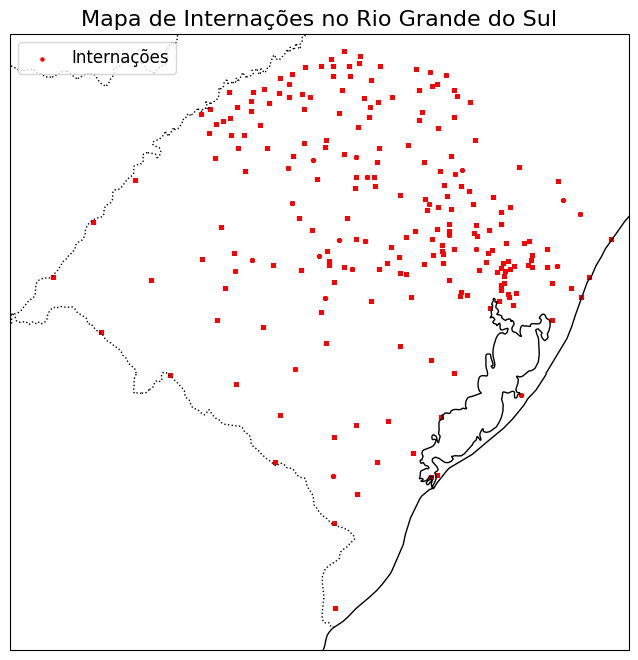

In [125]:
# 1. Criar as geometrias a partir dos dados originais
geometry = [Point(xy) for xy in zip(dados['longitude_h'], dados['latitude_h'])]

# 2. Criar o GeoDataFrame com o sistema de coordenadas WGS84 (EPSG:4326)
gdf = gpd.GeoDataFrame(dados, geometry=geometry, crs="EPSG:4326")

# 3. Filtrar valores inválidos (fora dos limites geográficos do sistema WGS84)
gdf = gdf[(gdf['longitude_h'] >= -180) & (gdf['longitude_h'] <= 180) &
          (gdf['latitude_h'] >= -90) & (gdf['latitude_h'] <= 90)]

# 4. Configurar o gráfico para usar o sistema de coordenadas
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Adicionar o mapa básico com limites de países
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

# Limitar o gráfico ao Rio Grande do Sul (coordenadas aproximadas)
ax.set_extent([-57.65, -49.5, -34.0, -27.0], crs=ccrs.PlateCarree())  # Ajuste os limites para o RS

# Plotar os pontos do GeoDataFrame no mapa
gdf.plot(ax=ax, marker='o', color='red', markersize=5, label='Internações')

# Adicionar título e legendas
plt.title('Mapa de Internações no Rio Grande do Sul', fontsize=16)
plt.legend(loc='upper left', fontsize=12)

# Exibir o gráfico
plt.show()

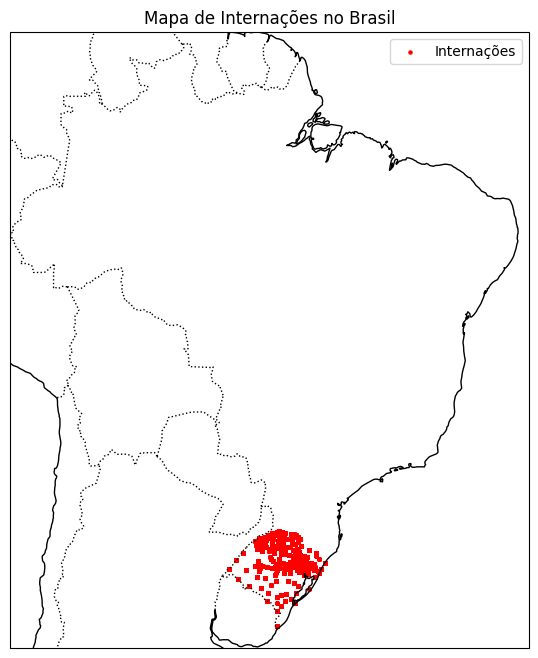

In [126]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 1. Criar as geometrias a partir dos dados originais
geometry = [Point(xy) for xy in zip(dados['longitude_h'], dados['latitude_h'])]

# 2. Criar o GeoDataFrame com o sistema de coordenadas WGS84 (EPSG:4326)
gdf = gpd.GeoDataFrame(dados, geometry=geometry, crs="EPSG:4326")

# 3. Filtrar valores inválidos (fora dos limites geográficos do sistema WGS84)
gdf = gdf[(gdf['longitude_h'] >= -180) & (gdf['longitude_h'] <= 180) &
          (gdf['latitude_h'] >= -90) & (gdf['latitude_h'] <= 90)]

# 4. Plotar os dados no mapa
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.set_extent([-74, -34, -35, 6], crs=ccrs.PlateCarree())  # Ajustar os limites para o Brasil
gdf.plot(ax=ax, marker='o', color='red', markersize=5, label='Internações')
plt.title('Mapa de Internações no Brasil')
plt.legend()
plt.show()


In [128]:
import pandas as pd

dados.to_csv('dados_RS.csv', index=False)

print("Arquivo 'dados_RS.csv' criado com sucesso!")

Arquivo 'dados_RS.csv' criado com sucesso!
